### IS4242 Group 8 Project

### Exploratory Data Analysis

Contents
- Class distribution
- N-gram analysis
- Cluster analysis (Document and word)
- Polarity analysis
- Perplexity analysis
- Burstiness analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

nltk.download("punkt")

from textblob import TextBlob
from spacy.lang.de.stop_words import STOP_WORDS

from scipy import spatial
import gensim.downloader as api
import time
import copy
import pickle

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Constants

TARGET_VARS = ["hate", "privacy", "sexual",
               "impersonation", "illegal", "advertisement", "ai"]
RANDOM_STATE = 420

### Exploring the processed dataset

In [3]:
df = pd.read_csv('data/processed/df_combined_processed_no_reddit_title_no_stem_no_lemma_2023-04-09.csv')
df

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                   kalleron design refuse collection recycling sites hear huge demand nowadays   
1                                                                                                                                                                                                                                                                                                 hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift   
2      milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas   
3                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
4                                                                                     temporarysection50 hi accepted job offer earlier month supervisor administrative staff ie receptionist assistants mail room clerks etc lead prior job aka right hand lady manager supervise staff members manager sick vacation rare supervisors keep morale positivewelcoming environment keep staff motivated supervisors amazing ones supervisor done make happy work environment anything helps thank   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...   
49093                                                                                                                                                                                                                                                                                                                                                                        contract mobile 11 mnths latest motorola nokia etc free double mins text orange tariffs pm callback remove records   
49094                                                                                                                                                                                                                                                                                                                                                                                         want latest video handset 750 anytime network mins half price line rental reply delivery tomorrow   
49095                                                                                                                           

### Target Class Exploration

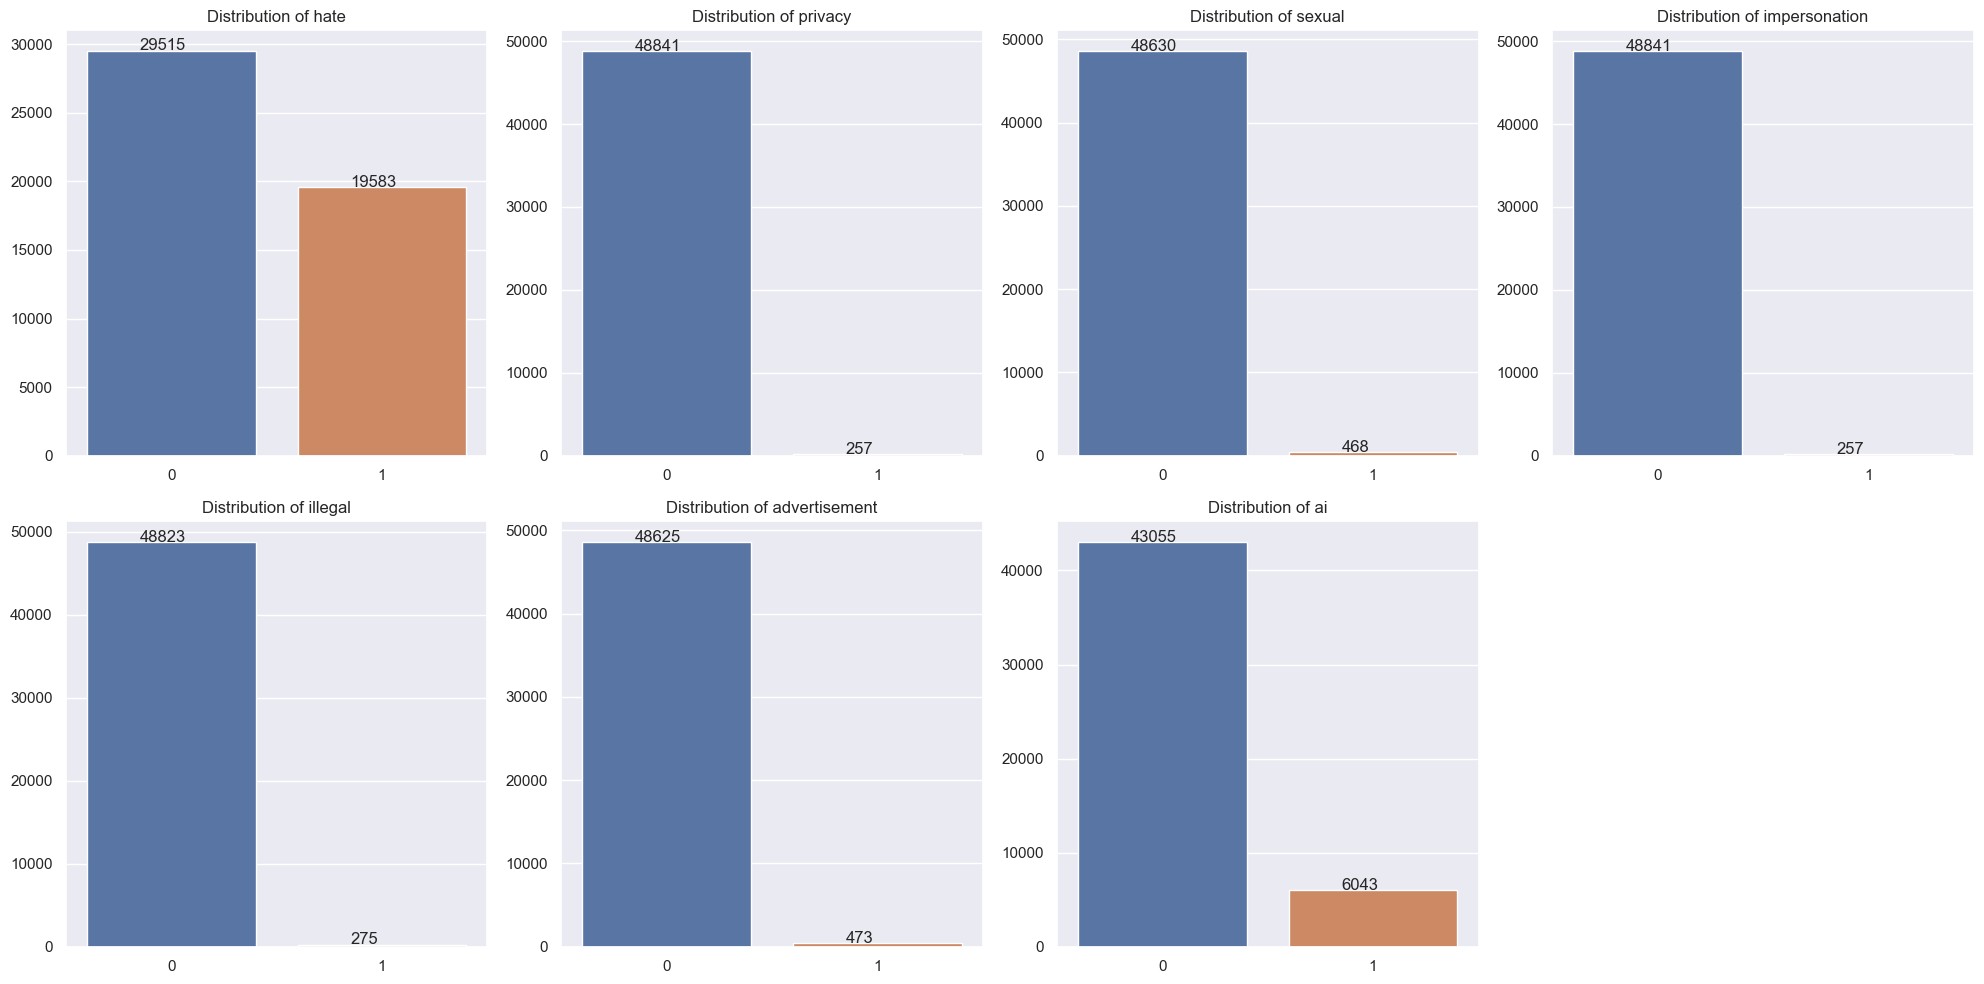

In [4]:
# Plotting the distribution of the target variables

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.countplot(data=df, x=TARGET_VARS[i], ax=ax)
        ax.set_title(f'Distribution of {TARGET_VARS[i]}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        # add counts to the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x()+0.25, p.get_height()+13))

    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Textual Exploration

#### N-Gram Analysis

In [5]:
# Calculating frequencies of n-grams

def n_gram_frequencies(text, n):
    '''This function takes in a text and n and returns a dictionary of n-grams and their frequencies.
    
    Args:
        text (str): The text to be processed
        n (int): The n in n-gram
        
    Returns:
        n_gram_freq (dict): A dictionary of n-grams and their frequencies
    '''

    # Splitting text into words
    words = str(text).split()

    # Creating n-grams
    n_grams = zip(*[words[i:] for i in range(n)])

    # Calculating frequencies
    n_gram_freq = {}
    for n_gram in n_grams:
        n_gram = " ".join(n_gram)
        if n_gram in n_gram_freq:
            n_gram_freq[n_gram] += 1
        else:
            n_gram_freq[n_gram] = 1

    return n_gram_freq


def combine_n_gram_dicts_row_wise(n_gram_dict, combined_dict):
    '''This function takes in a dictionary of n-grams and their frequencies and combines it with another dictionary.
    
    Args:
        n_gram_dict (dict): A dictionary of n-grams and their frequencies
        combined_dict (dict): A dictionary of n-grams and their frequencies
        
    Returns:
        combined_dict (dict): A dictionary of n-grams and their frequencies
    '''

    for key, value in n_gram_dict.items():
        if key in combined_dict:
            combined_dict[key] += value
        else:
            combined_dict[key] = value
    return n_gram_dict


def generate_n_gram_dicts(df):
    '''This function takes in a dataframe and returns dictionaries of n-grams and their frequencies for all rows.
    
    Args:
        df (pd.DataFrame): A dataframe containing the text to be processed
        
    Returns:
        all_data_1_gram (dict): A dictionary of n-grams and their frequencies
        all_data_2_gram (dict): A dictionary of n-grams and their frequencies
        all_data_3_gram (dict): A dictionary of n-grams and their frequencies
    '''

    all_data_1_gram = {}
    all_data_2_gram = {}
    all_data_3_gram = {}
    df["n-grams_1"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_1_gram))
    df["n-grams_2"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_2_gram))
    df["n-grams_3"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_3_gram))
    return all_data_1_gram, all_data_2_gram, all_data_3_gram


def convert_dict_to_df(word_frequencies, min_freq=1):
    '''This function takes in a dictionary of n-grams and their frequencies and returns a dataframe.
    
    Args:
        word_frequencies (dict): A dictionary of n-grams and their frequencies
        
    Returns:
        word_frequencies_df (pd.DataFrame): A dataframe of n-grams and their frequencies
    '''

    word_frequencies_df = pd.DataFrame.from_dict(
        word_frequencies, orient='index', columns=['Frequency'])
    word_frequencies_df = word_frequencies_df.sort_values(
        by='Frequency', ascending=False)
    word_frequencies_df = word_frequencies_df.reset_index().rename(columns={
        'index': 'Word'})
    word_frequencies_df = word_frequencies_df[word_frequencies_df['Frequency'] >= min_freq]
    return word_frequencies_df


def generate_wordcloud_from_freq(word_frequencies, var):
    '''This function takes in a dictionary of n-grams and their frequencies and returns a wordcloud.
    
    Args:
        word_frequencies (dict): A dictionary of n-grams and their frequencies
        var (str): The variable name to be used in the title of the wordcloud

    Returns:
        None        
    '''

    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=word_frequencies)
    # Display the generated image:
    fig, ax = plt.subplots(figsize=(16, 20))
    ax.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for {var}", fontsize=20)
    plt.show()


def generate_n_gram_analysis(df):
    '''This function takes in a dataframe and returns n-gram analysis for all rows.
    
    Args:
        df (pd.DataFrame): A dataframe containing the text to be processed
        
    Returns:
        None
    '''
    
    for i in range(1, 4):
        df[f"n-grams_{i}"] = df["body"].apply(
            lambda x: n_gram_frequencies(x, i))

    # all data
    print("All Data")
    all_data_1_gram, all_data_2_gram, all_data_3_gram = generate_n_gram_dicts(
        df)
    print("All Data - 1-gram")
    display(convert_dict_to_df(all_data_1_gram).head(15))
    generate_wordcloud_from_freq(all_data_1_gram, "All Data - 1-gram")
    print("All Data - 2-gram")
    display(convert_dict_to_df(all_data_2_gram).head(15))
    generate_wordcloud_from_freq(all_data_2_gram, "All Data - 2-gram")
    print("All Data - 3-gram")
    display(convert_dict_to_df(all_data_3_gram).head(15))
    generate_wordcloud_from_freq(all_data_3_gram, "All Data - 3-gram")

    for var in TARGET_VARS:

        var_df = df[df[var] == 1]
        print(f"{var} data")
        var_1_gram, var_2_gram, var_3_gram = generate_n_gram_dicts(var_df)
        if var_1_gram:
            print(f"{var} data - 1-gram")
            display(convert_dict_to_df(var_1_gram).head(15))
            generate_wordcloud_from_freq(var_1_gram, f"{var} data - 1-gram")
        else:
            print(f"No 1-gram data for {var}. \n")

        if var_2_gram:
            print(f"{var} data - 2-gram")
            display(convert_dict_to_df(var_2_gram).head(15))
            generate_wordcloud_from_freq(var_2_gram, f"{var} data - 2-gram")
        else:
            print(f"No 2-gram data for {var}. \n")

        if var_3_gram:
            print(f"{var} data - 3-gram")
            display(convert_dict_to_df(var_3_gram).head(15))
            generate_wordcloud_from_freq(var_3_gram, f"{var} data - 3-gram")
        else:
            print(f"No 3-gram data for {var}. \n")

        print("=================================================================================================")

All Data
All Data - 1-gram


Word  Frequency
0     bitch       8161
1        rt       7584
2      like       6305
3        im       4284
4       get       3640
5      dont       3127
6   bitches       3069
7       one       2880
8      time       2451
9      good       2352
10     hoes       2347
11    would       2308
12      got       2228
13   people       2155
14     know       2142

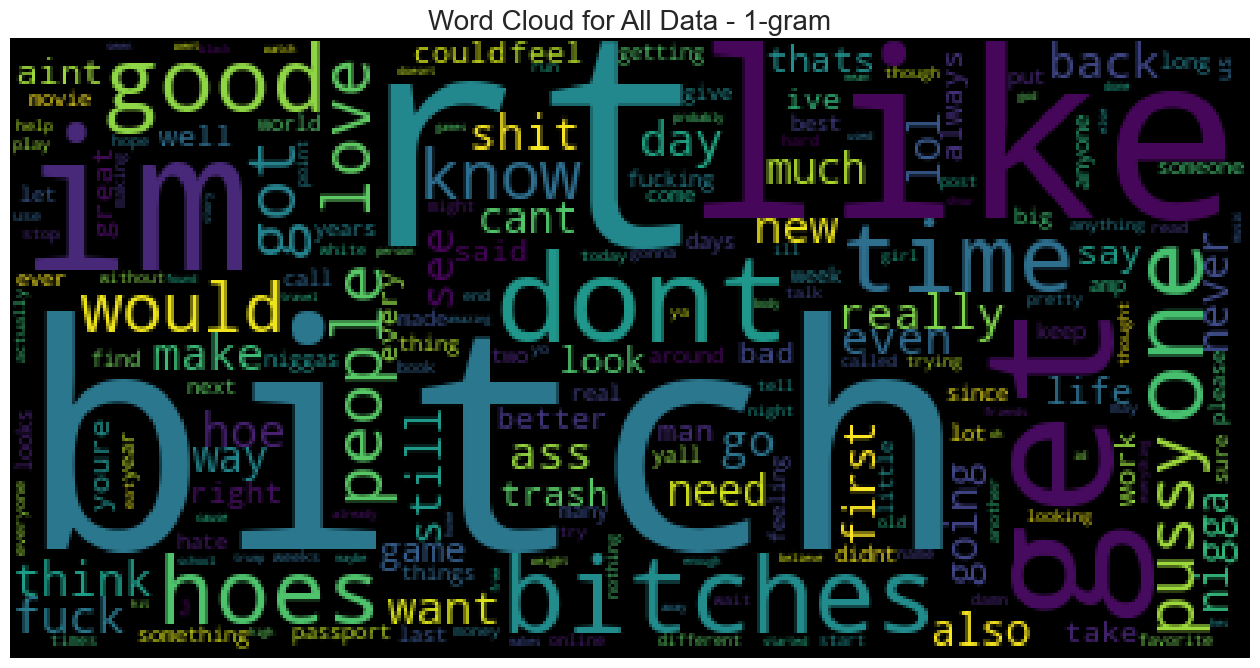

All Data - 2-gram


Word  Frequency
0     feel like        362
1     look like        283
2     dont know        257
3    looks like        238
4     bitch ass        236
5    like bitch        208
6      yo bitch        189
7     bad bitch        185
8     cant wait        185
9     ass bitch        184
10   first time        163
11    dont want        158
12  bad bitches        155
13    dont like        150
14     bitch im        149

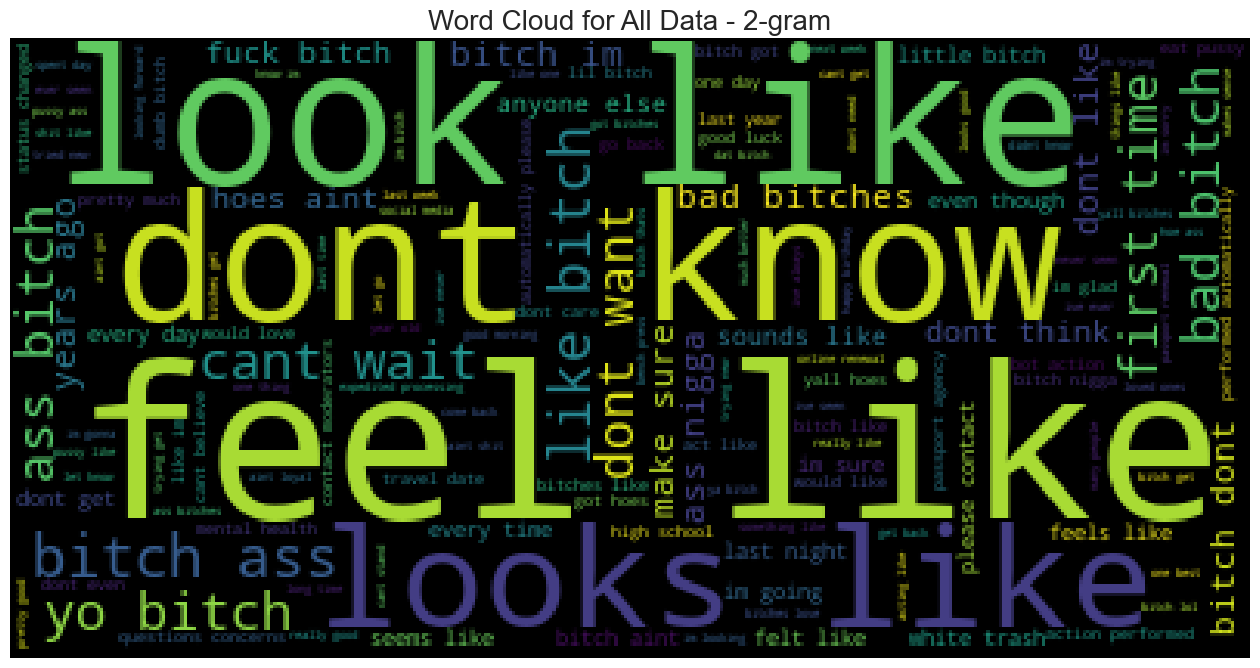

All Data - 3-gram


Word  Frequency
0        please contact moderators         99
1     automatically please contact         99
2             bot action performed         99
3   action performed automatically         99
4   performed automatically please         99
5                  hoes aint loyal         65
6                  bitch ass nigga         53
7          suggestion support harm         47
8            support harm violence         47
9              harm violence death         47
10             violence death rule         47
11           death rule violations         47
12          rule violations result         47
13             criteria bot action         47
14          hate speech suggestion         47

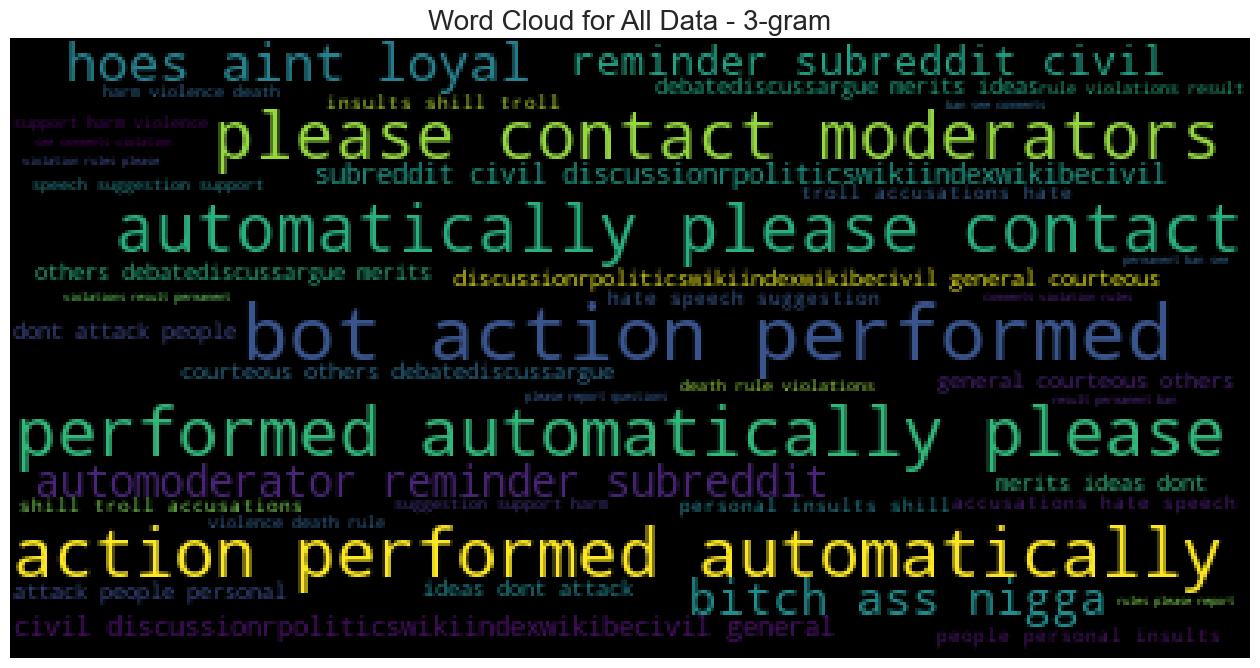

hate data
hate data - 1-gram


Word  Frequency
0     bitch       7932
1        rt       5945
2   bitches       3012
3      like       2342
4      hoes       2277
5     pussy       2028
6       hoe       1800
7        im       1783
8      dont       1514
9       ass       1439
10     fuck       1369
11      get       1250
12     shit       1223
13      got       1149
14     aint       1095

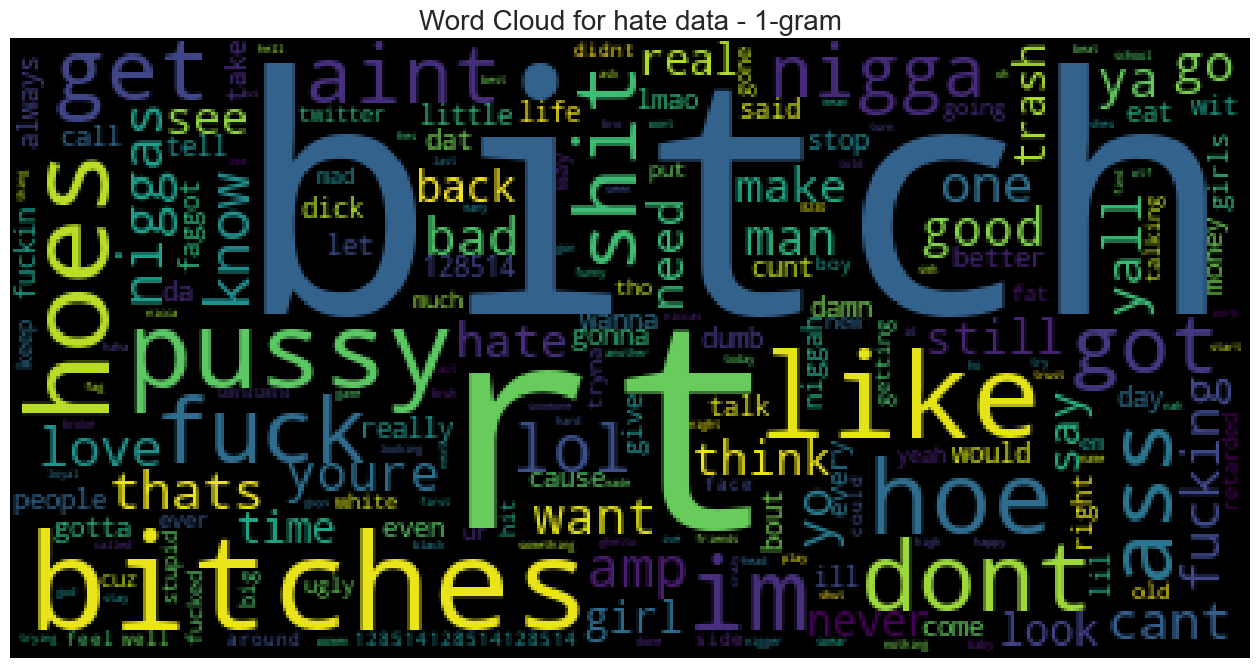

hate data - 2-gram


Word  Frequency
0      bitch ass        222
1     like bitch        199
2       yo bitch        185
3      bad bitch        184
4      ass bitch        177
5      look like        155
6    bad bitches        154
7       bitch im        145
8     bitch dont        137
9      hoes aint        125
10    fuck bitch        118
11  little bitch        117
12    bitch aint        108
13     ass nigga        107
14     lil bitch         93

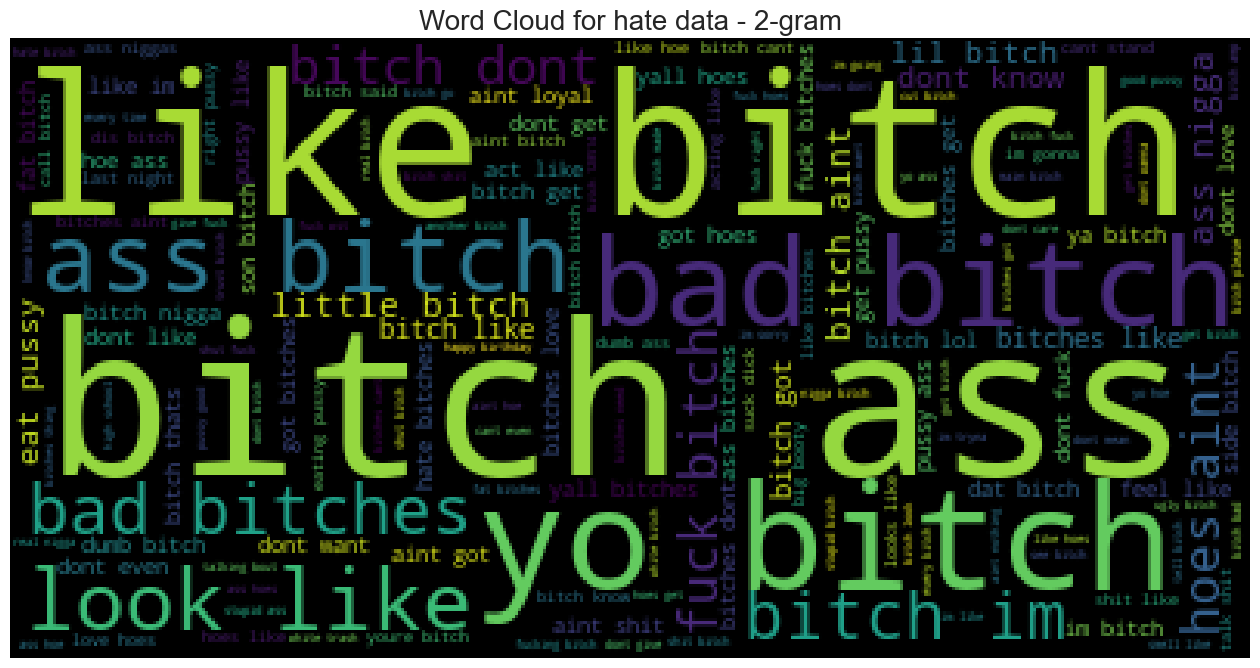

hate data - 3-gram


Word  Frequency
0      hoes aint loyal         65
1      bitch ass nigga         46
2       dont love hoes         31
3   bitches thing like         25
4      bitch look like         24
5    bad bitches thing         24
6     fuck right pussy         23
7     stupid ass bitch         23
8         yo bitch ass         22
9       dont give fuck         19
10      ass bitch aint         19
11       hoe ass nigga         18
12   bitches aint shit         17
13      cunt cunt cunt         13
14   bitch aint fuckin         13

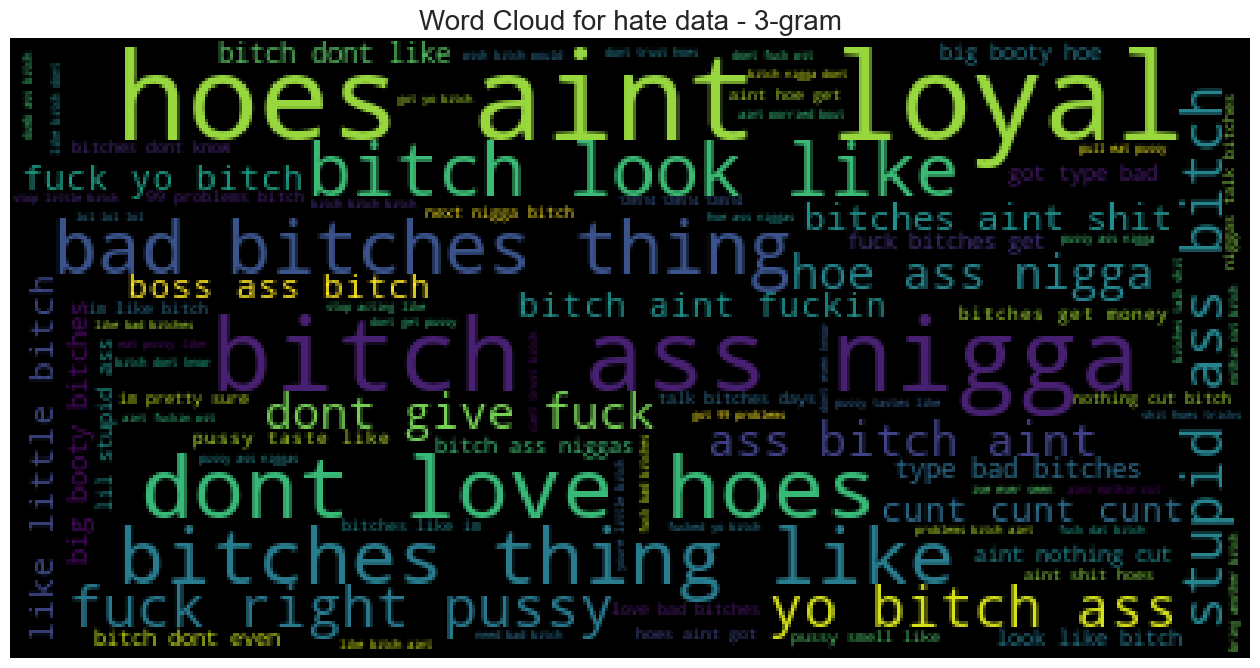

privacy data
privacy data - 1-gram


Word  Frequency
0          know         47
1        number         46
2         phone         38
3            st         38
4           new         29
5           555         25
6       address         21
7          call         21
8         place         20
9        anyone         17
10        found         17
11           im         16
12        house         16
13          get         16
14  randomnames         15

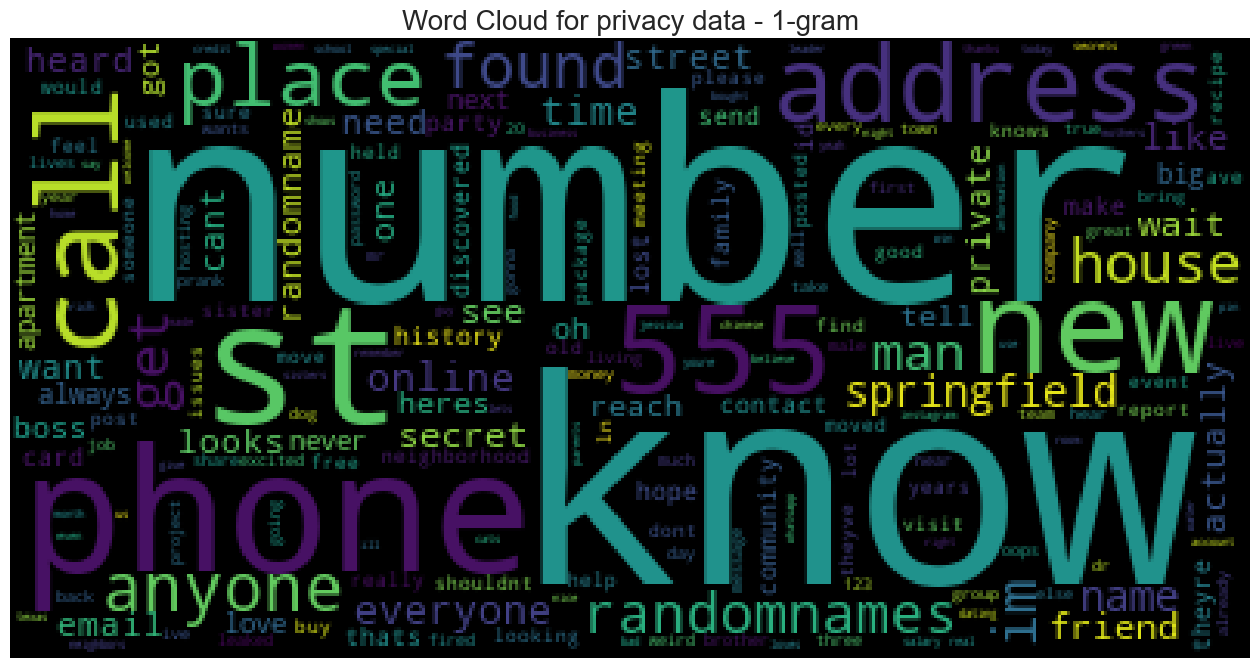

privacy data - 2-gram


Word  Frequency
0             phone number         30
1           st springfield         14
2               number 555         11
3                new place          9
4            new apartment          7
5                cant wait          7
6         found randomname          6
7                 call 555          5
8   discovered randomnames          5
9                  st cant          5
10               reach 555          5
11        know randomnames          5
12               feel free          4
13      randomnames secret          4
14            anyone wants          4

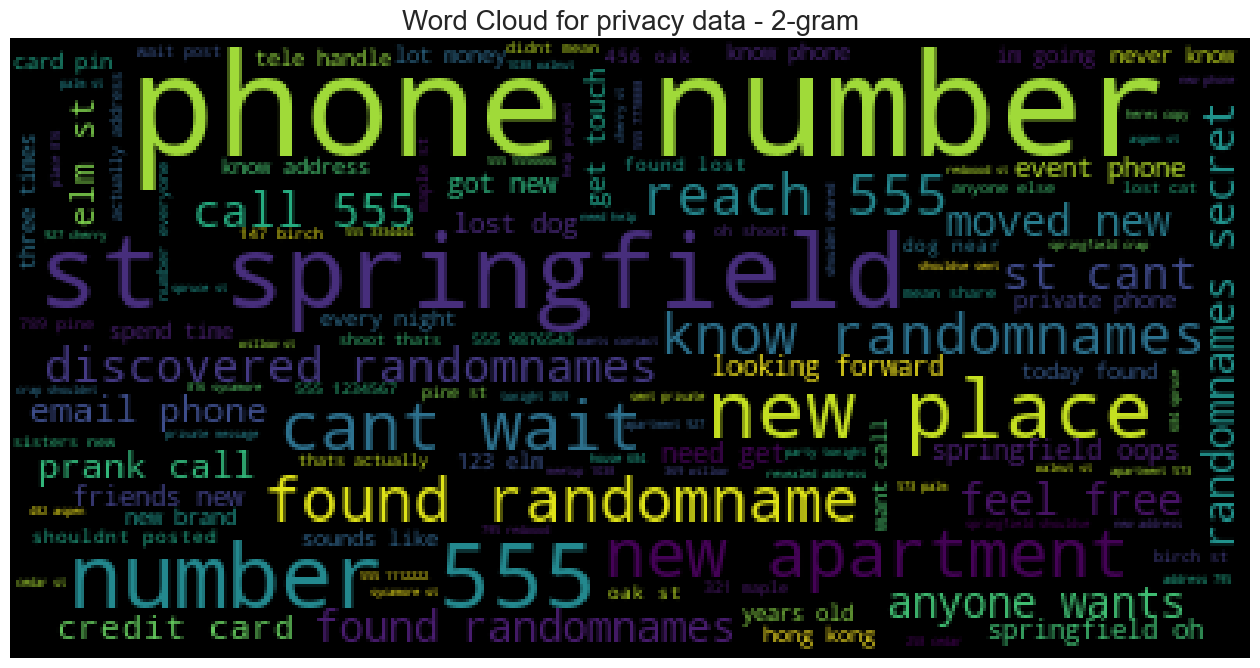

privacy data - 3-gram


Word  Frequency
0                phone number 555         10
1                    st cant wait          5
2   discovered randomnames secret          4
3              email phone number          3
4             st springfield oops          3
5               st springfield oh          3
6                  need get touch          3
7              event phone number          3
8                   684 spruce st          2
9                house 684 spruce          2
10               new phone number          2
11                cousin move new          2
12                  369 willow st          2
13             st looking forward          2
14            st springfield crap          2

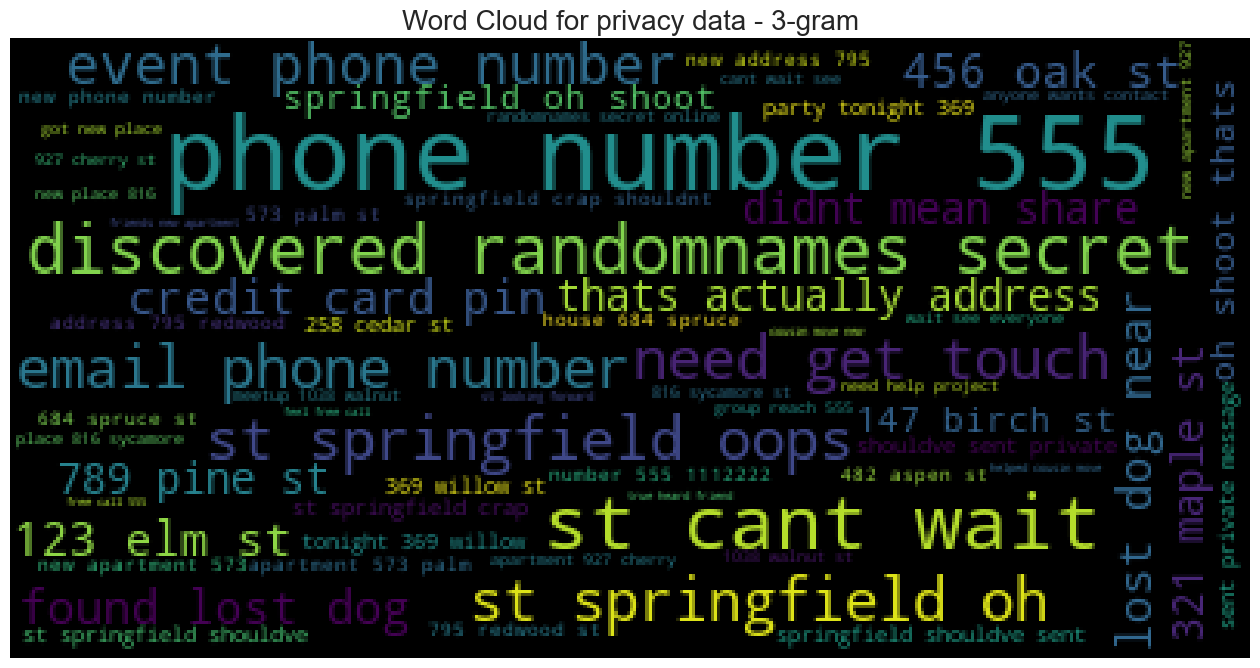

sexual data
sexual data - 1-gram


Word  Frequency
0         ass         60
1        love         57
2        sexy         41
3       pussy         40
4         sex         33
5        fuck         32
6       would         31
7        like         31
8        good         29
9         eat         26
10        get         25
11       want         24
12       porn         22
13  beautiful         22
14        hot         20

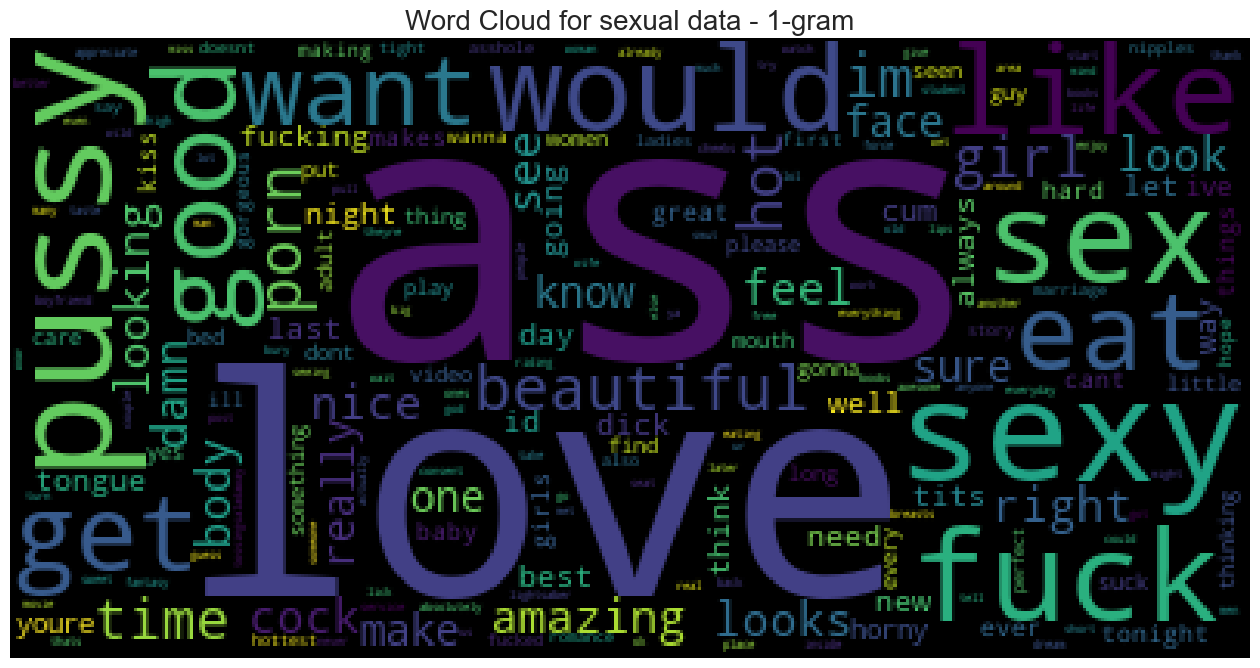

sexual data - 2-gram


Word  Frequency
0        id love         10
1     would love          8
2     last night          8
3      ever seen          6
4      cant wait          5
5      feel like          5
6        eat ass          5
7    amazing ass          5
8       love eat          5
9       sex play          4
10  look amazing          4
11    looks good          4
12    eating ass          4
13     sweet ass          4
14     new adult          4

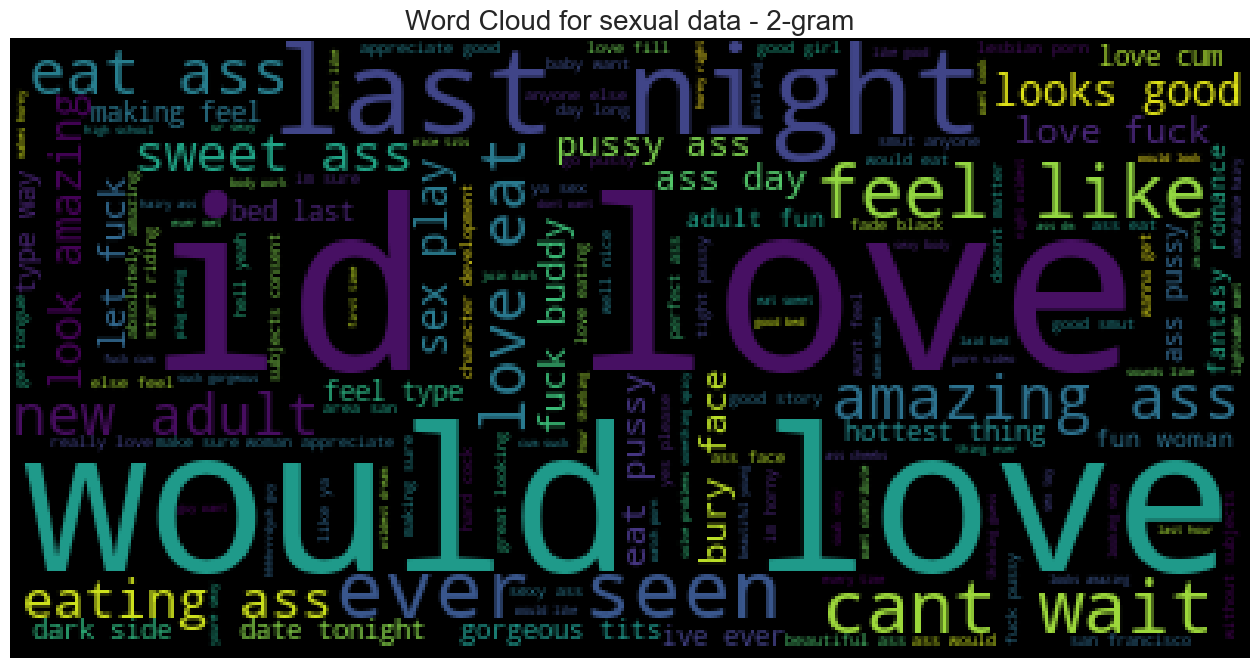

sexual data - 3-gram


Word  Frequency
0         sweet ass pussy          3
1             eat ass day          3
2        making feel type          3
3           feel type way          3
4             id love cum          2
5    appreciate good smut          2
6           love cum suck          2
7      area san francisco          2
8           eat sweet ass          2
9           new adult fun          2
10        adult fun woman          2
11   fun woman appreciate          2
12       damn makes horny          2
13      makes horny right          2
14  woman appreciate good          2

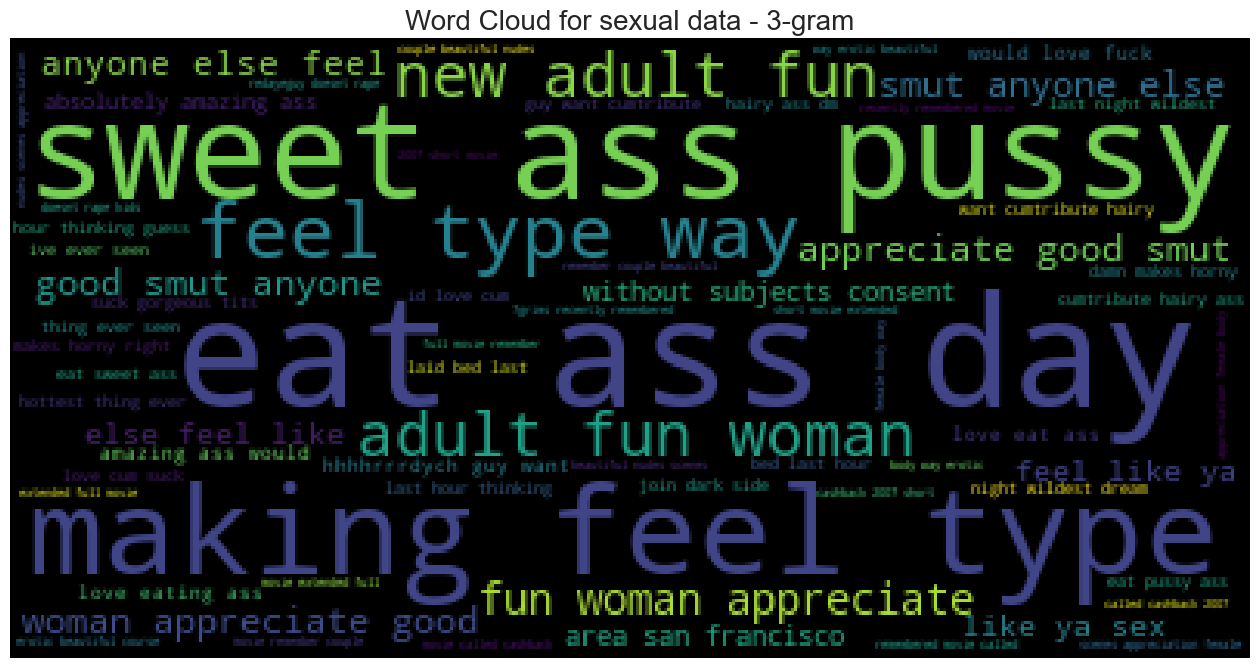

impersonation data
impersonation data - 1-gram


Word  Frequency
0         im        189
1   inviting         26
2       join         25
3        hey         23
4       free         23
5        new         18
6    hosting         17
7    charity         16
8       away         16
9     giving         15
10  offering         14
11      next         14
12   concert         12
13      fans         12
14      like         12

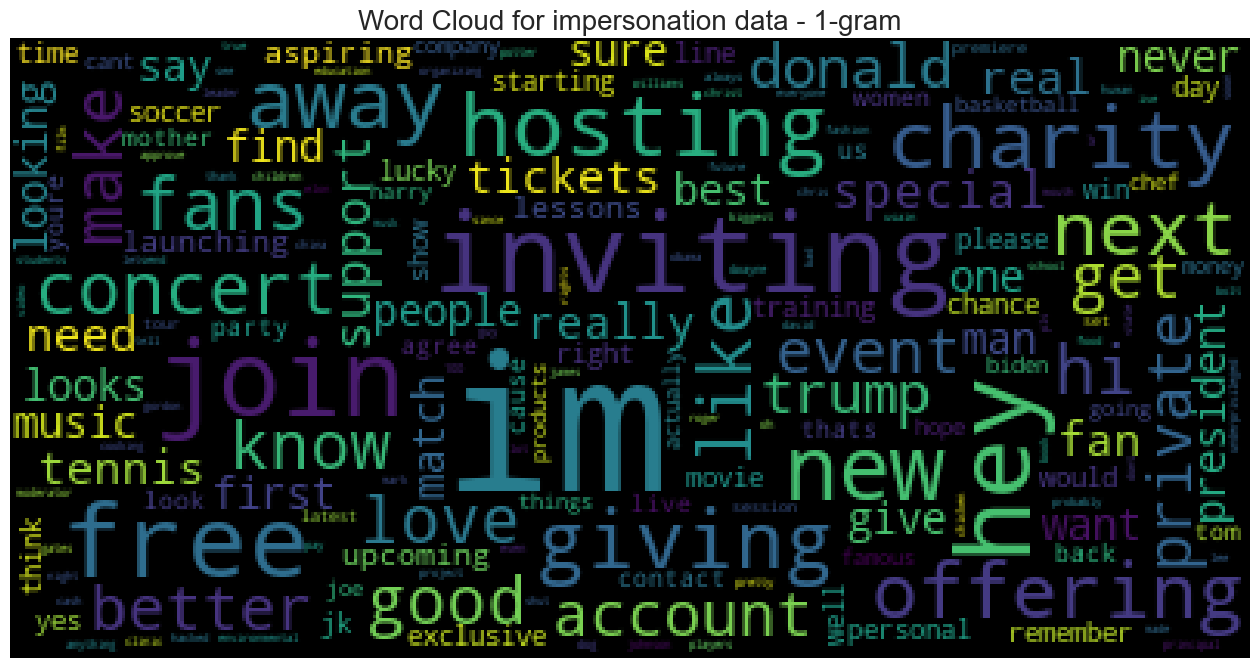

impersonation data - 2-gram


Word  Frequency
0       im inviting         25
1        im hosting         16
2       giving away         15
3     inviting join         15
4         im giving         14
5       im offering         14
6         away free         12
7     offering free          8
8   hosting charity          8
9      donald trump          6
10     free tickets          6
11     im launching          6
12    charity event          5
13        lucky fan          5
14     next concert          5

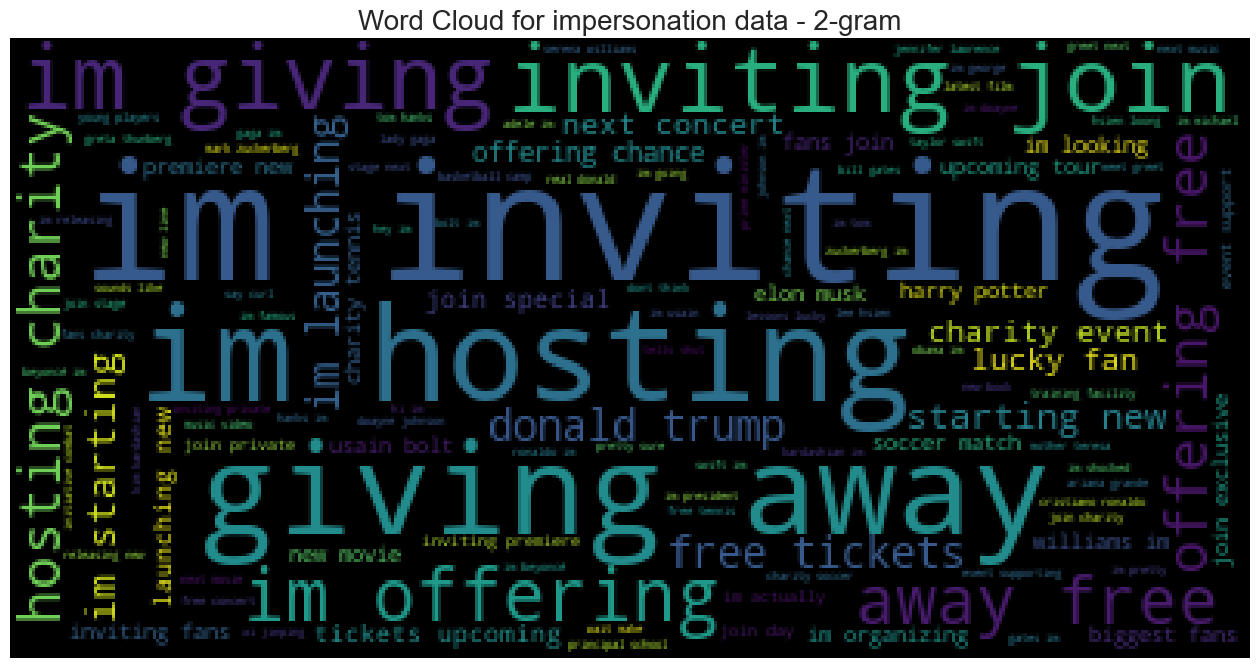

impersonation data - 3-gram


Word  Frequency
0        im inviting join         15
1          im giving away         14
2        giving away free         12
3        im offering free          8
4      im hosting charity          8
5       away free tickets          6
6      im offering chance          5
7         im starting new          5
8        im launching new          4
9   free tickets upcoming          3
10  hosting charity event          3
11   williams im inviting          3
12  inviting join private          3
13       im inviting fans          3
14   im inviting premiere          3

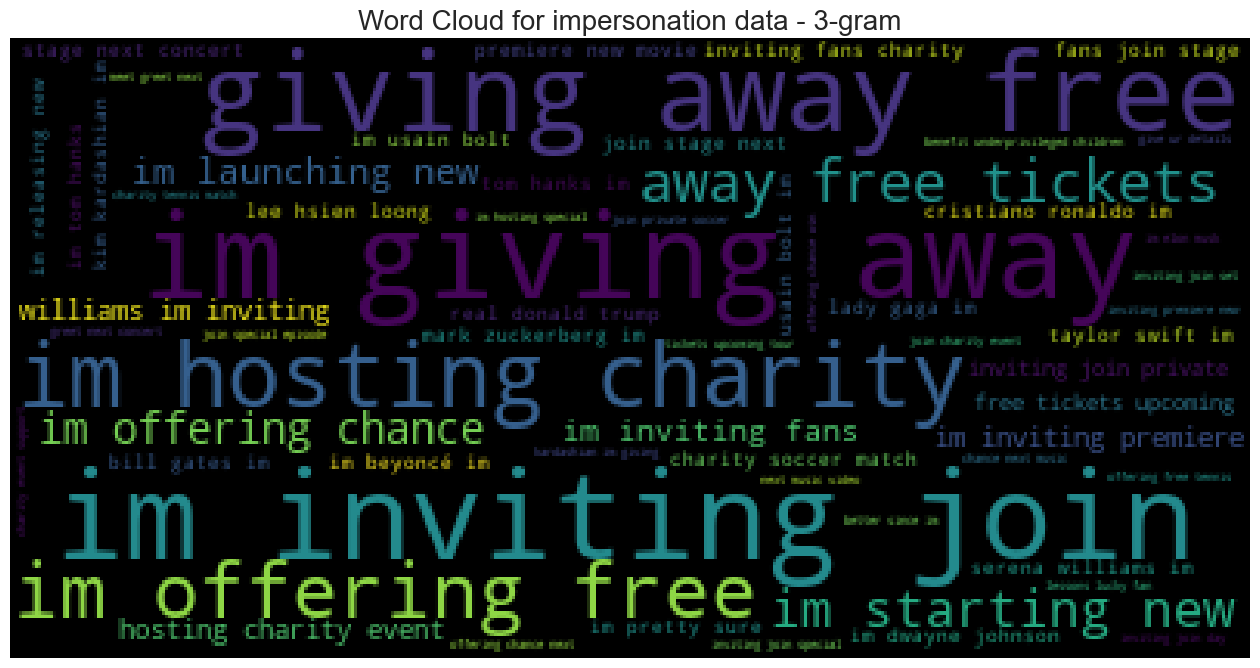

illegal data
illegal data - 1-gram


Word  Frequency
0        im         32
1      like         30
2       get         29
3      know         26
4      make         22
5      want         22
6      dont         20
7      time         19
8    people         18
9     drugs         18
10     good         17
11      one         15
12     even         13
13   really         13
14  someone         13

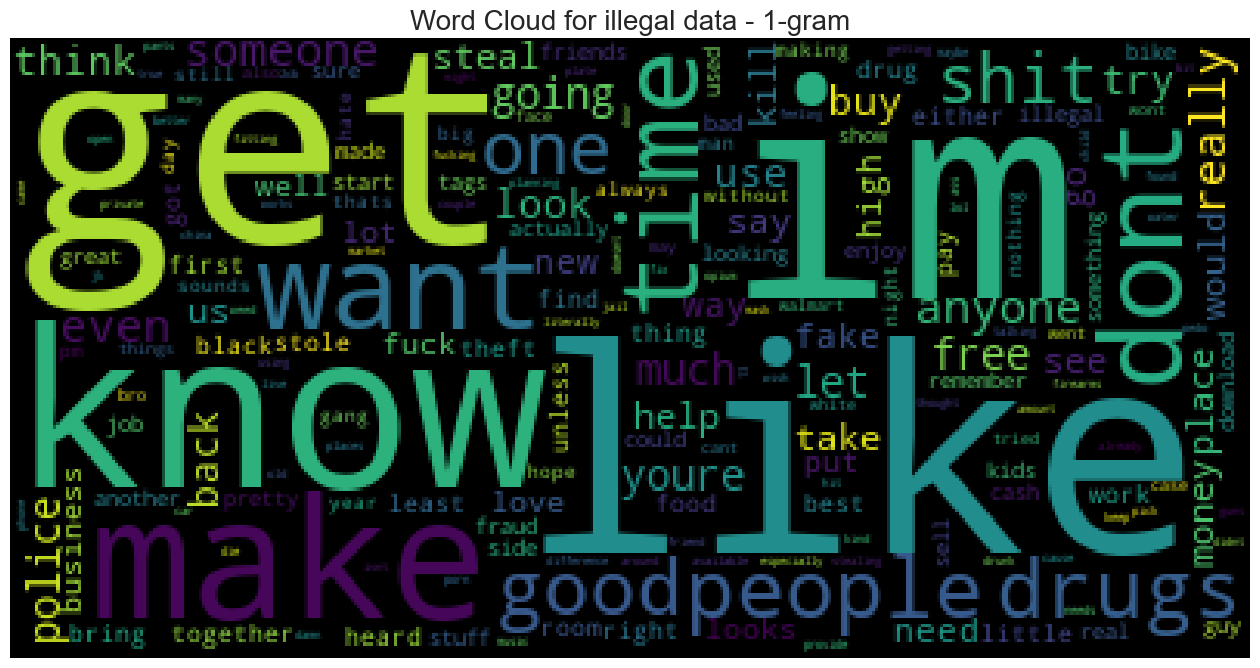

illegal data - 2-gram


Word  Frequency
0     sounds like          5
1        im going          3
2        let know          3
3    fitting room          3
4       white sox          3
5     im planning          3
6     anyone help          3
7   license plate          3
8         dont go          3
9         im sure          3
10       want try          3
11   unless stole          3
12    im thinking          3
13      look like          3
14     im looking          3

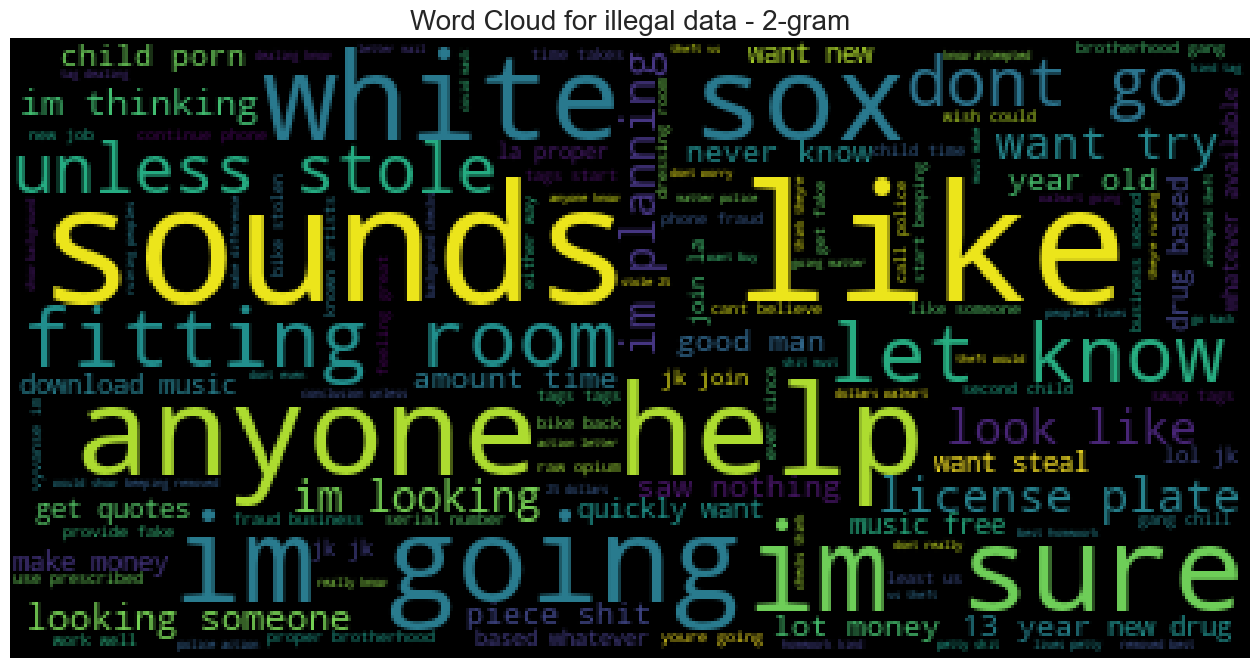

illegal data - 3-gram


Word  Frequency
0         im looking someone          3
1       matter police action          2
2       continue phone fraud          2
3   based whatever available          2
4                  lol jk jk          2
5                 jk jk join          2
6                 jk join la          2
7             join la proper          2
8      la proper brotherhood          2
9    proper brotherhood gang          2
10    brotherhood gang chill          2
11      phone fraud business          2
12            new drug based          2
13     fraud business second          2
14     business second child          2

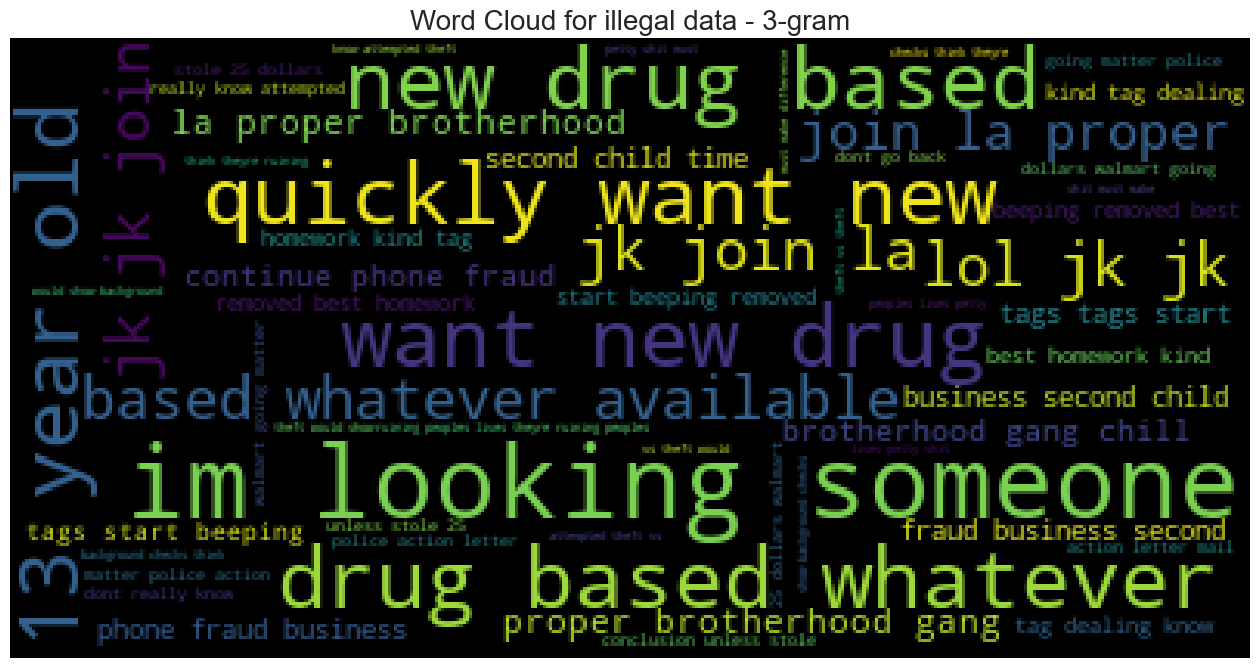

advertisement data
advertisement data - 1-gram


Word  Frequency
0          get         82
1         free         64
2          new         57
3           ur         53
4         call         51
5     pandabuy         47
6      product         45
7     products         44
8       online         41
9      service         36
10  experience         36
11       found         35
12      please         34
13         use         34
14        time         33

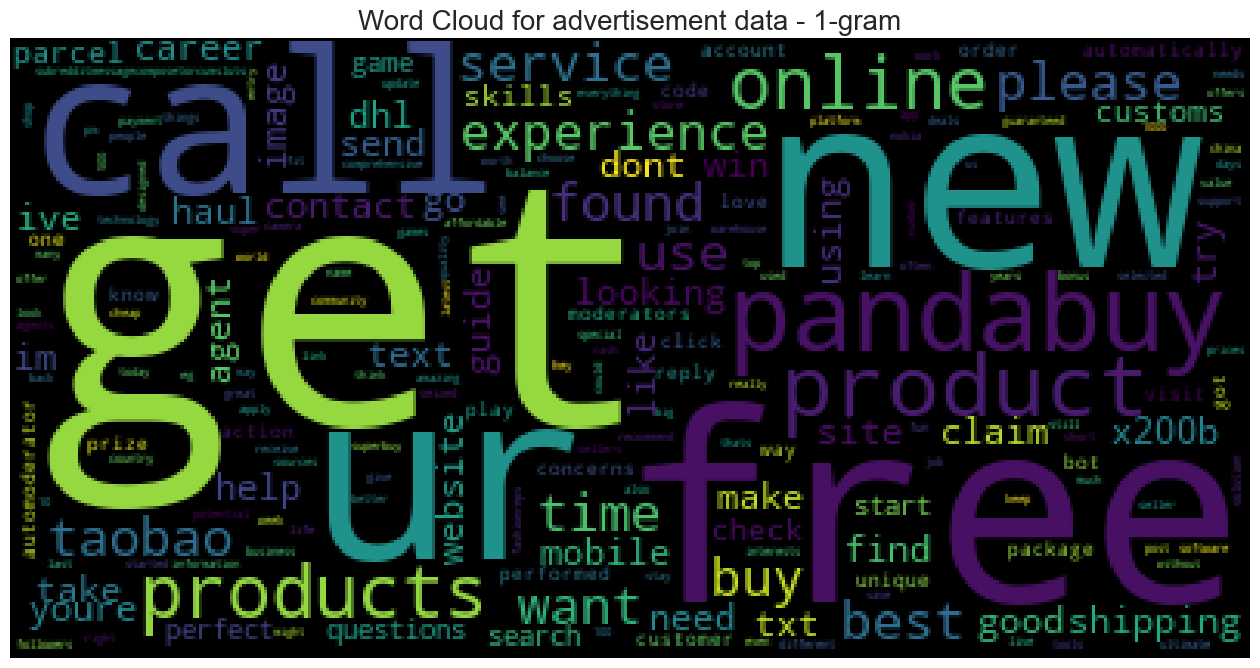

advertisement data - 2-gram


Word  Frequency
0                                  please contact         18
1                                action performed         16
2                              contact moderators         16
3                              questions concerns         16
4    subredditmessagecomposetorcumsluts questions         16
5                                      bot action         16
6   moderators subredditmessagecomposetorcumsluts         16
7                         performed automatically         16
8                            automatically please         16
9                           automoderator looking         10
10                                  looking image         10
11                                  image sources         10
12                                product perfect          9
13                                      dont miss          9
14                             commercial invoice          8

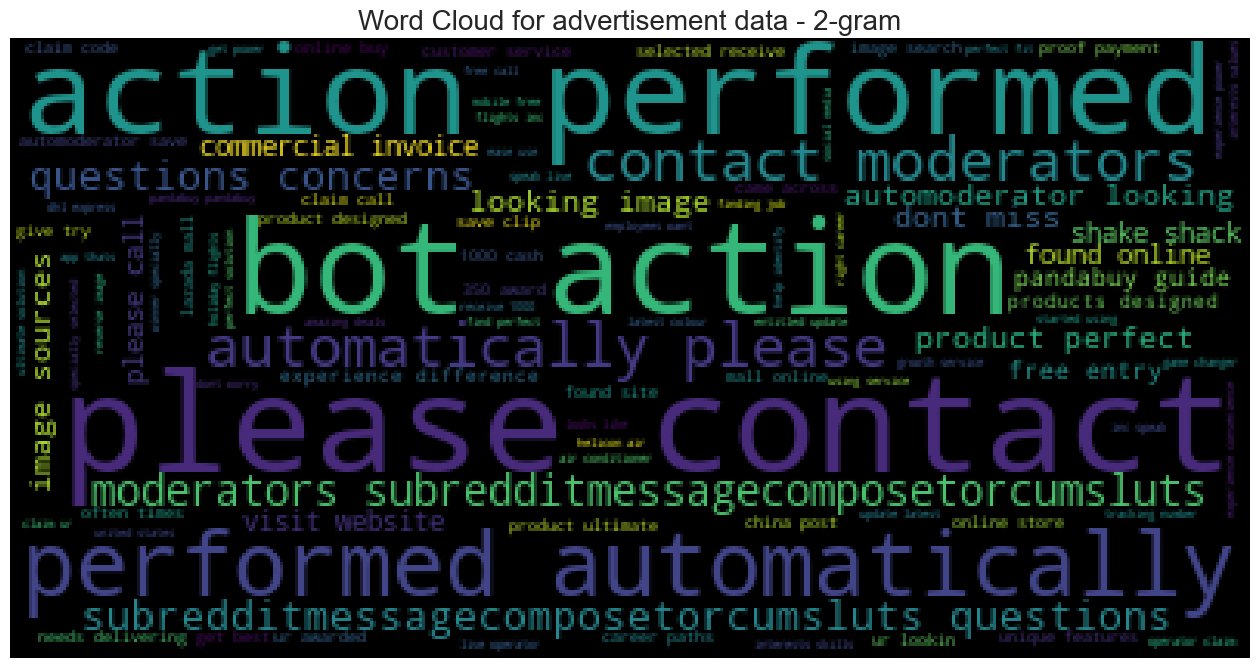

advertisement data - 3-gram


Word  Frequency
0                                 please contact moderators         16
1                            performed automatically please         16
2     contact moderators subredditmessagecomposetorcumsluts         16
3   moderators subredditmessagecomposetorcumsluts questions         16
4     subredditmessagecomposetorcumsluts questions concerns         16
5                            action performed automatically         16
6                                      bot action performed         16
7                              automatically please contact         16
8                                     looking image sources         10
9                               automoderator looking image         10
10                                  automoderator save clip          6
11                                          mall online buy          6
12                                       lazada mall online          6
13                                    selected receive 1000          4
14                                      live operator claim          4

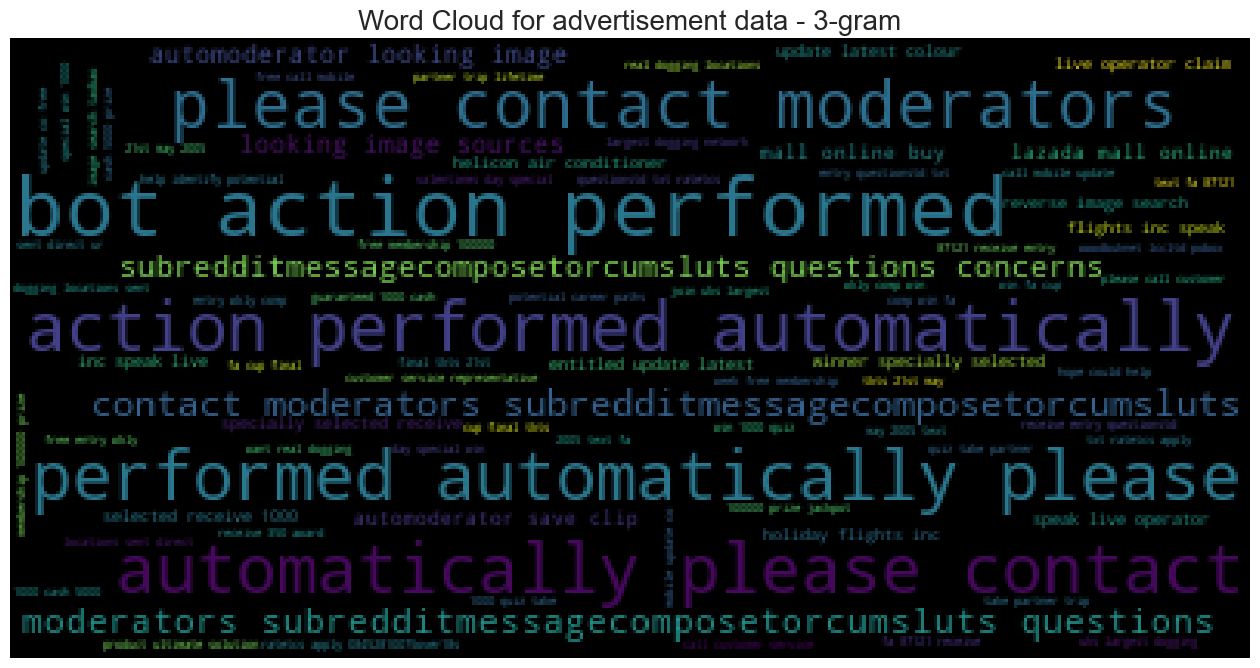

ai data
ai data - 1-gram


Word  Frequency
0       new        501
1   feeling        471
2      life        374
3      love        347
4        im        310
5       day        272
6       joy        265
7      time        254
8    beauty        250
9     world        237
10     make        219
11     like        206
12     good        201
13     cant        199
14      art        197

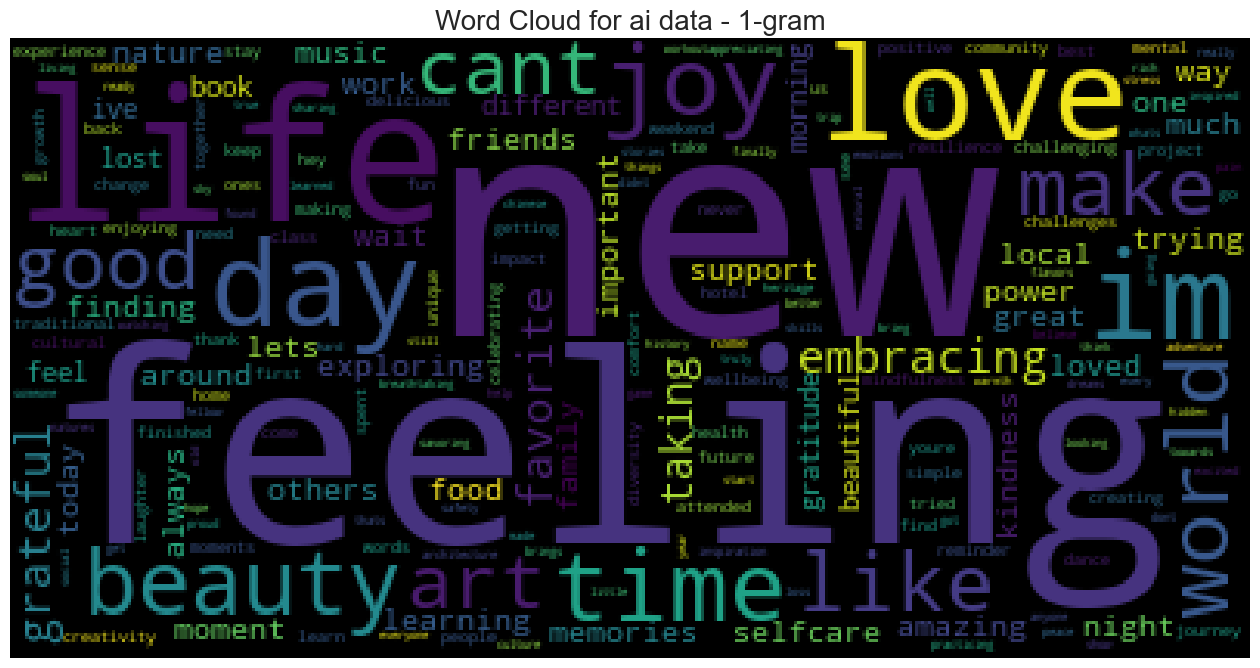

ai data - 2-gram


Word  Frequency
0          cant wait         82
1         loved ones         72
2          tried new         55
3       cant believe         53
4          spent day         52
5         hotel name         48
6         trying new         47
7       good morning         47
8      mental health         46
9   feeling grateful         43
10        didnt feel         42
11         good book         38
12     exploring new         36
13      year project         34
14   positive impact         34

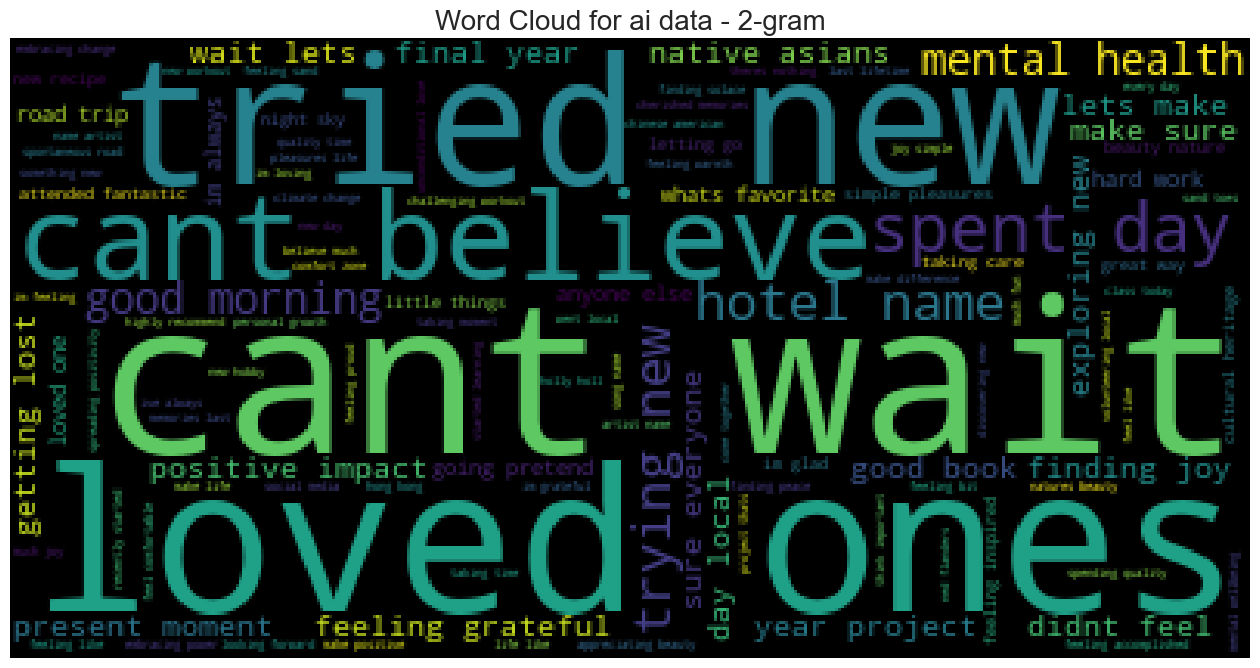

ai data - 3-gram


Word  Frequency
0       final year project         34
1       make sure everyone         29
2           lets make sure         29
3          spent day local         29
4           wait lets make         29
5         name artist name         21
6         song name artist         21
7    spending quality time         17
8        cant believe much         17
9    spontaneous road trip         16
10  didnt feel comfortable         16
11  memories last lifetime         15
12      year project thats         15
13   simple pleasures life         15
14       didnt feel secure         14

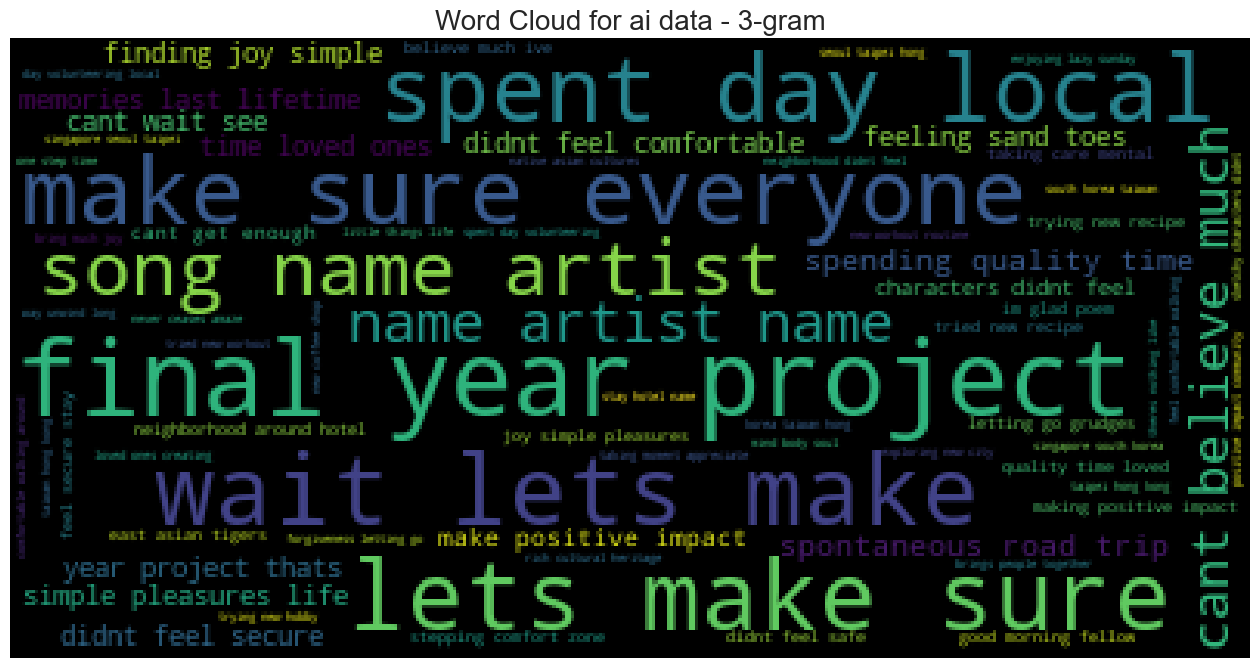

In [6]:
df_n_gram = df.copy()
generate_n_gram_analysis(df_n_gram)

## Cluster Analysis

- Document level analysis
- Word level analysis

#### Document Level Analysis

In [7]:
df

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                   kalleron design refuse collection recycling sites hear huge demand nowadays   
1                                                                                                                                                                                                                                                                                                 hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift   
2      milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas   
3                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
4                                                                                     temporarysection50 hi accepted job offer earlier month supervisor administrative staff ie receptionist assistants mail room clerks etc lead prior job aka right hand lady manager supervise staff members manager sick vacation rare supervisors keep morale positivewelcoming environment keep staff motivated supervisors amazing ones supervisor done make happy work environment anything helps thank   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...   
49093                                                                                                                                                                                                                                                                                                                                                                        contract mobile 11 mnths latest motorola nokia etc free double mins text orange tariffs pm callback remove records   
49094                                                                                                                                                                                                                                                                                                                                                                                         want latest video handset 750 anytime network mins half price line rental reply delivery tomorrow   
49095                                                                                                                           

In [4]:
def vectorise_text(text):
    '''This function takes in a list of text and returns a vectorised representation of the text.
    
    Args:
        text (list): A list of text to be vectorised
        
    Returns:
        X (np.array): A vectorised representation of the text
    '''

    vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
    X = vectorizer.fit_transform(text)
    return X

def elbow_method_clustering(X, max_clusters=20):
    '''This function takes in a vectorised representation of text and returns a plot of the elbow method.
    
    Args:
        X (np.array): A vectorised representation of the text
        max_clusters (int): The maximum number of clusters to be used in the elbow method
        
    Returns:
        None
    '''

    Sum_of_squared_distances = []
    K = range(2,max_clusters)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.figure(figsize=(10, 10))
    sns.lineplot(x=K, y=Sum_of_squared_distances, marker=True)
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()        

def cluster_text(text, X, n_clusters=5):
    '''This function takes in a list of text, a vectorised representation of the text and the number of clusters to be used and returns a dataframe containing the text and the cluster number.
    
    Args:
        text (list): A list of text to be clustered
        X (np.array): A vectorised representation of the text
        n_clusters (int): The number of clusters to be used
        
    Returns:
        clusters (pd.DataFrame): A dataframe containing the text and the cluster number
    '''
    
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['body','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    return clusters


In [5]:
X = vectorise_text(df["body"])

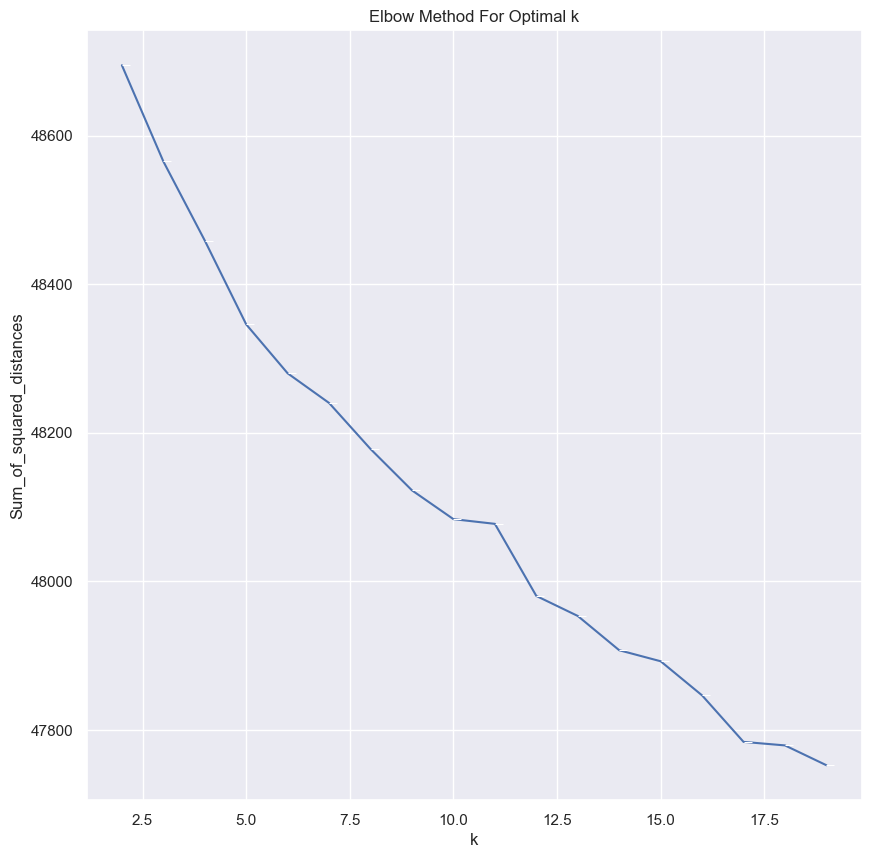

In [15]:
elbow_method_clustering(X, max_clusters=20)

In [6]:
n_clusters = 10
cluster_df = cluster_text(df['body'], X, n_clusters=4)

In [8]:
for cluster in range(n_clusters):
    print(f"Cluster {cluster}")
    display(cluster_df[cluster_df['cluster'] == cluster].head(12))
    print("=================================================================================================")

Cluster 0


body  \
7744                                                                                       m0derat0r41 pedo bitch nine still prison   
10078                                                         yyzsteven sounds like quintessential toxic corporate boss bitch adios   
13046        kitreia brother forgotten remember short c64 got nes cant remember far back young bitch upset beat score marathon game   
13485                                                                                                al3x5 ass kicking outfit bitch   
14249  cabinguy11 freely admit dont understand ins outs lawsuit dont get sony much bitch much money anybody making 10 year old game   
22427                                                 rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit   
22429                                                        rt shenikaroberts shit hear might true might faker bitch told ya 57361   
22431                                                                       brighterdays sit hate another bitch got much shit going   
22433                                                                                         amp might get ya bitch back amp thats   
22434                                                                               rhythmixx hobbies include fighting mariam bitch   
22435                                                                  keeks bitch curves everyone lol walked conversation like smh   
22436                                                                                                    murda gang bitch gang land   

       cluster  
7744         0  
10078        0  
13046        0  
13485        0  
14249        0  
22427        0  
22429        0  
22431        0  
22433        0  
22434        0  
22435        0  
22436        0

Cluster 1


body  \
15249                                                                                                         ca2dogs boats hoes   
22430                                       tmadisonx shit blows meclaim faithful somebody still fucking hoes 128514128514128514   
22437                                                                                                hoes smoke losers yea go ig   
22447                                                                                                  cant see hoes wont change   
22463                                                                                        lames crying hoes thats tears clown   
22464                                                                                          like snoop said 94 dont love hoes   
22466                                                                         hated hoes favorite 2mw sevenone httptcobmdsvmc3rc   
22468                                                                                              pimps pimps hoes future voice   
22474                                                                                     hoes like niggas spend money talk bout   
22476                                                                     yall niggas cuffing hoes cause yall aint never bitches   
22479  128514128514128514128514128514128514128514128514128514128514128514vandalsavage teanna trump probably cleaner twitter hoes   
22520                                                                     causewereguys going back school sucks dick hoes attend   

       cluster  
15249        1  
22430        1  
22437        1  
22447        1  
22463        1  
22464        1  
22466        1  
22468        1  
22474        1  
22476        1  
22479        1  
22520        1

Cluster 2


body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              kalleron design refuse collection recycling sites hear huge demand nowadays   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift   
2                                                                                                                                                                                                                                 milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                      rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
4                                                                                                                                                                                                                                                                                                                temporarysection50 hi accepted job offer earlier month supervisor administrative staff ie receptionist assistants mail room clerks etc lead prior job aka right hand lady manager supervise staff members manager sick vacation rare supervisors keep morale positivewelcoming environment keep staff motivated supervisors amazing ones supervisor done make happy work environment anything helps thank   
5                                                                                                          glitterenthusiast congratulations new role supervisory title resume officially puts one rank last position smile literally leadership capacity couple things come mind regarding new role establish rapport new employees open communicating intention open communication opendoor policy etc also try genuinely get know new team mates employees spending time understanding context 

Cluster 3


body  \
7670                                      lordclooch thats happens bitches throw gang signs   
15832                       theownerxo always little mexican bitches devouring us white men   
22432              8220selfiequeenbri cause im tired big bitches coming us skinny girls8221   
22438                                                                bad bitches thing like   
22443                                                              bitches get cut everyday   
22456                               id say im back old old bitches would get excited 128524   
22459                                     im done bitter bitches wrap angry bird theres app   
22462                                                jus meet son ya mane ass bitches shots   
22473                                                   bitches even worst theyll send guys   
22475                                                             dont trust niggas bitches   
22477  dodge bullet 128517 8220darealkha da bitches cut pregnant bound thank god 1285918221   
22478                                             young pill chamberlain bitches love music   

       cluster  
7670         3  
15832        3  
22432        3  
22438        3  
22443        3  
22456        3  
22459        3  
22462        3  
22473        3  
22475        3  
22477        3  
22478        3

Cluster 4


Empty DataFrame
Columns: [body, cluster]
Index: []

Cluster 5


Empty DataFrame
Columns: [body, cluster]
Index: []

Cluster 6


Empty DataFrame
Columns: [body, cluster]
Index: []

Cluster 7


Empty DataFrame
Columns: [body, cluster]
Index: []

Cluster 8


Empty DataFrame
Columns: [body, cluster]
Index: []

Cluster 9


Empty DataFrame
Columns: [body, cluster]
Index: []

#### Word Level Analysis

In [11]:
# Constructing dictionary of unique words from raw text

def construct_dictionary(text, combined_dict):
    '''This function takes in a string of text and a dictionary and returns a dictionary containing the unique words from the string of text.
    
    Args:
        text (str): A string of text
        combined_dict (dict): A dictionary containing the unique words from the string of text
        
    Returns:
        combined_dict (dict): A dictionary containing the unique words from the string of text
    '''

    # Constructing dictionary
    for word in text.split():
        if word not in combined_dict:
            combined_dict[word] = len(combined_dict)

    return combined_dict

def generate_dict(df):
    '''This function takes in a dataframe and returns a dictionary containing the unique words from the dataframe.
    
    Args:
        df (pd.DataFrame): A dataframe containing the text to be vectorised
        
    Returns:
        output_dict (dict): A dictionary containing the unique words from the dataframe
    '''

    output_dict = {}
    df["body"].apply(lambda x: construct_dictionary(x, output_dict))
    return output_dict

# Download and pickle pre-trained model

def download_model(model_name):
    '''This function takes in a model name and downloads the model from the internet and saves it.
    
    Args:
        model_name (str): The name of the model to be downloaded
        
    Returns:
        None
    '''
    time_start = time.time()
    model = api.load(model_name)
    print(f"INFO: model loaded in {time.time() - time_start} seconds")
    with open(f"cache_files/{model_name}.pickle", "wb") as f:
        pickle.dump(model, f)

def load_model(model_name):
    '''This function takes in a model name and loads the model from the cache.
    
    Args:
        model_name (str): The name of the model to be loaded
        
    Returns:
        model (gensim.models.keyedvectors.Word2VecKeyedVectors): The model
    '''

    with open(f"cache_files/{model_name}.pickle", "rb") as f:
        model = pickle.load(f)
    return model

# Get embeddings from pre-trained model

def get_embeddings(model, word):
    '''This function takes in a model and a word and returns the embeddings of the word.
    
    Args:
        model (gensim.models.keyedvectors.Word2VecKeyedVectors): The model
        word (str): The word to be vectorised
        
    Returns:
        np.array: The embeddings of the word
    '''

    if model.__contains__(word):
        return np.array(model[word])
    else:
        return None

# Transforming text to vector using a pre-trained model glove-wiki-gigaword-50

def transform_text_to_vector(dictionary):
    '''This function takes in a dictionary and returns a dictionary containing the vectorised text.
    
    Args:
        dictionary (dict): A dictionary containing the unique words from the string of text
        
    Returns:
        vectorised_text (dict): A dictionary containing the vectorised text
    '''
    
    # Transforming text to vector
    try:
        model = load_model("glove-wiki-gigaword-50")
        print("INFO: glove-wiki-gigaword-50 loaded.")
    except:
        print("INFO: Downloading glove-wiki-gigaword-50 loaded.")
        download_model("glove-wiki-gigaword-50")
        model = load_model("glove-wiki-gigaword-50")
        print("INFO: glove-wiki-gigaword-50 loaded.")


    vectorised_text = {}
    print("INFO: Transforming text to vector.")
    for word in dictionary.keys():
        if get_embeddings(model, word) is not None:
            vectorised_text[word] = get_embeddings(model, word)

    return vectorised_text

# Clustering vectors using k-means

def cluster_vectors(vectorised_text, n_clusters=3, n_samples=100, display=False):
    '''This function takes in a dictionary containing the vectorised text and returns a dataframe containing the vectorised text and the cluster number.
    
    Args:
        vectorised_text (dict): A dictionary containing the vectorised text
        n_clusters (int): The number of clusters to be used
        n_samples (int): The number of samples to be used for visualisation
        display (bool): Whether to display the visualisation

    Returns:
        vectors_2d (pd.DataFrame): A dataframe containing the vectorised text and the cluster number
    '''

    # Clustering vectors
    print(f"INFO: Clustering vectors using k-means for n_clusters = {n_clusters}.")    
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(list(vectorised_text.values()))

    # Calculating within cluster sum of squares
    print("INFO: Calculating within cluster sum of squares.")
    wcss = kmeans.inertia_

    # Transforming vectors to 2D space for visualisation
    print("INFO: Transforming vectors to 2D space for visualisation.")
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    vectors_2d = tsne.fit_transform(np.array(list(vectorised_text.values())))

    # Creating dataframe for visualisation
    print("INFO: Creating dataframe for visualisation.")
    vectors_2d = pd.DataFrame(vectors_2d, columns=['x', 'y'])
    vectors_2d['cluster'] = kmeans.labels_
    vectors_2d['word'] = list(vectorised_text.keys())

    # Sampling 100 points for visualisation
    print("INFO: Sampling 100 points for visualisation.")
    vectors_2d = vectors_2d.sample(min(n_samples, vectors_2d.shape[0]))
    vectors_2d = vectors_2d.reset_index(drop=True)

    # Visualising clusters
    if display:
        print("INFO: Visualising clusters.")
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.scatterplot(x='x', y='y', hue='cluster', data=vectors_2d, ax=ax)

        # annotating points
        for i, point in vectors_2d.iterrows():
            ax.text(point.x, point.y, point.word, fontsize=12)
            
        plt.title(f"Clusters of words for n_clusters = {n_clusters}", fontsize=20)
        plt.show()

    # Assigning cluster to each word
    print("INFO: Assigning cluster to each word.")
    for i, word in enumerate(vectorised_text.keys()):
        vectorised_text[word] = kmeans.labels_[i]
        
    return vectorised_text, vectors_2d, wcss

# Elbow method for determining optimal number of clusters

def elbow_method(df, max_clusters=10, display=True):
    '''This function takes in a dataframe and returns a plot of the elbow method.
    
    Args:
        df (pd.DataFrame): A dataframe containing the text
        max_clusters (int): The maximum number of clusters to be used
        display (bool): Whether to display the plot
        
    Returns:
        None
    '''
    
    dictionary = generate_dict(df)

    wcss = []
    for i in range(2, max_clusters+1):
        vectorised_text = transform_text_to_vector(dictionary)
        _, _, wcss_ = cluster_vectors(vectorised_text, n_clusters=i, display=display)
        wcss.append(wcss_)
    # plotting the results onto a line graph using seaborn
    plt.figure(figsize=(10, 10))
    sns.lineplot(x=range(1, max_clusters), y=wcss)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') # within cluster sum of squares
    plt.show()


INFO: Downloading glove-wiki-gigaword-50 loaded.
INFO: model loaded in 29.837966680526733 seconds
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 2.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 3.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 4.
INFO: Calculating within cluster sum of s

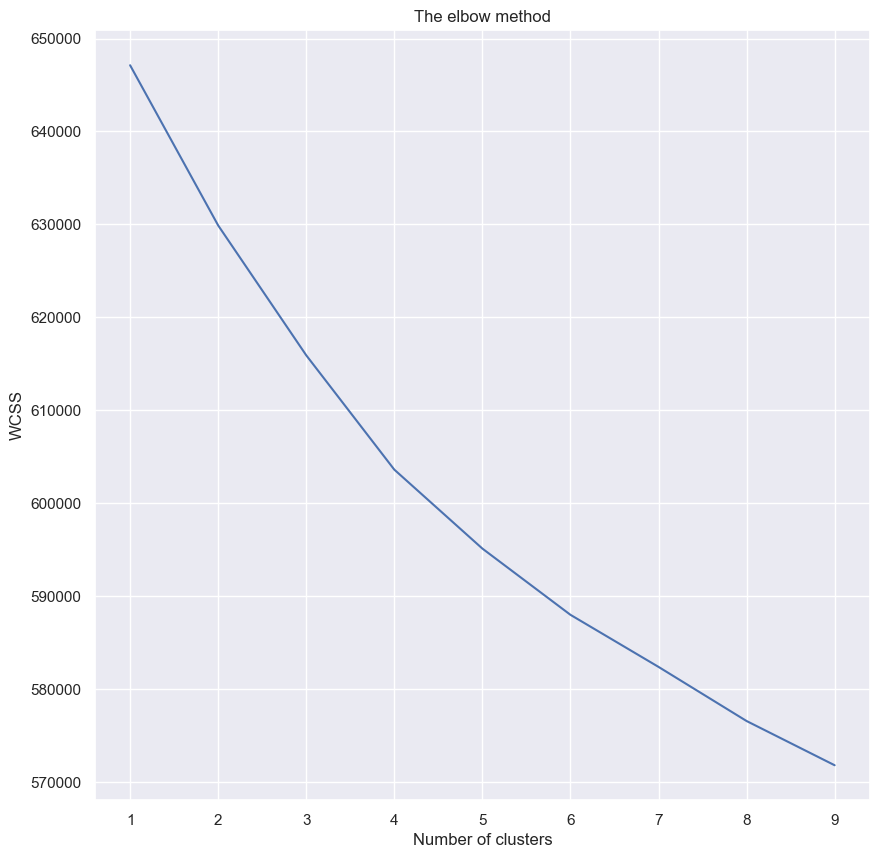

In [12]:
elbow_method(df, max_clusters=10, display=False)

In [13]:
n_clusters = 4
n_samples = 100
dictionary = generate_dict(df)
vectorised_text = transform_text_to_vector(dictionary)

vectorised_text_output, vectors_2d, wcss = cluster_vectors(vectorised_text, n_clusters=n_clusters, n_samples=n_samples)

INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 4.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Assigning cluster to each word.


In [14]:
word_clusters = pd.DataFrame(vectorised_text_output, index=["Cluster"]).T.reset_index().rename(columns={"index": "Word"})

In [15]:
for cluster in range(n_clusters):
    # print(f"Cluster {cluster}")
    display(word_clusters[word_clusters["Cluster"] == cluster].head(20))
    # print("=================================================================================================")


Word  Cluster
9                 hi        0
11          graduate        0
15           analyst        0
31               hey        0
34          bachelor        0
60          engineer        0
98               min        0
107       supervisor        0
111     receptionist        0
112       assistants        0
118              aka        0
121             lady        0
122          manager        0
140            thank        0
141  congratulations        0
172            mates        0
240      interviewer        0
247            coach        0
336            hello        0
426        graduated        0

Word  Cluster
26         mentors        1
29         clarity        1
30        navigate        1
133        amazing        1
152          smile        1
153      literally        1
162        rapport        1
164  communicating        1
169      genuinely        1
179         styles        1
191         insert        1
217        stalked        1
233          sleep        1
239         nerves        1
246       simulate        1
256         overdo        1
262       relaxing        1
267      happiness        1
268         breads        1
299         jargon        1

Word  Cluster
36      informatics        2
42   bioinformatics        2
70            maths        2
72              etc        2
110              ie        2
212             fid        2
218        linkedin        2
250              qa        2
255            dont        2
272              gl        2
279            isnt        2
300     freelancing        2
301      monetizing        2
308    kickstarting        2
316           youre        2
337             ive        2
354            mods        2
360              im        2
372      locational        2
373          flairs        2

Word  Cluster
0        design        3
1        refuse        3
2    collection        3
3     recycling        3
4         sites        3
5          hear        3
6          huge        3
7        demand        3
8      nowadays        3
10    economics        3
12        years        3
13   experience        3
14         risk        3
16      looking        3
17         make        3
18       career        3
19        shift        3
20       people        3
21    community        3
22  development        3

## Polarity Analysis

In [16]:
# Polarity analysis for text

def polarity_analysis(text):
    '''This function takes in a string of text and returns the polarity of the text.
    
    Args:
        text (str): A string of text
        
    Returns:
        polarity (float): The polarity of the text
    '''
    
    polarity = TextBlob(text).sentiment.polarity
    return polarity

df["polarity"] = df["body"].apply(lambda x: polarity_analysis(x))

In [17]:
# Previewing text with highest polarity

df.sort_values(by="polarity", ascending=False).head(10)[["body", "polarity"]]

body  \
17909                                              savoring smoky savory flavors perfectly grilled barbecue ribs bbqribs grilling   
17425                                                                                                                   best meal   
18249  switching roles pretending chef sharing imaginary cooking adventures delicious recipes masterchefwannabe culinarypretender   
22348                                                                              found perfect dress upcoming event fashionista   
1473                                    thegrandwazoo looks awesome tastebuds would sue attempted murder amount heat dish packing   
22401                                                                               got best news made deans list hardworkpaysoff   
3362                                        denimcryptid disney still donates republican party deserve applause performative best   
30788                                                                              cant tell mexico impressive brazil trash today   
18190                                                                                 hey go hiking weekend weather looks perfect   
30644                                             bt dubz ur best pals bitch quite often stoplivingafuckinglie hatredisincreasing   

       polarity  
17909       1.0  
17425       1.0  
18249       1.0  
22348       1.0  
1473        1.0  
22401       1.0  
3362        1.0  
30788       1.0  
18190       1.0  
30644       1.0

In [18]:
# Previewing text with lowest polarity

df.sort_values(by="polarity", ascending=True).head(10)[["body", "polarity"]]

body  \
3106   flimsyshallot guy makes trump look like run mill troublemaker god save us evil bastard takes control   
48613                                                                     looks nasty befitting people like   
16613                                                 always posting hobbies one cares hobbyobsessed boring   
45286                                                                        worst bm world smh bitch devil   
16614                                        art terrible stop pretending like youre artist badart notalent   
40541                        rt xtraxtralex disgusted betrayed hurt amp pussy drier niggas skin winter time   
341               okone3240 refuse leave country matter horror stories read absolutely terrifying get plane   
5954                                                                                    stevil77 disgusting   
5956                                                               pieceofrat thats disgusting amount money   
44395                                                                                           bitch nasty   

       polarity  
3106       -1.0  
48613      -1.0  
16613      -1.0  
45286      -1.0  
16614      -1.0  
40541      -1.0  
341        -1.0  
5954       -1.0  
5956       -1.0  
44395      -1.0

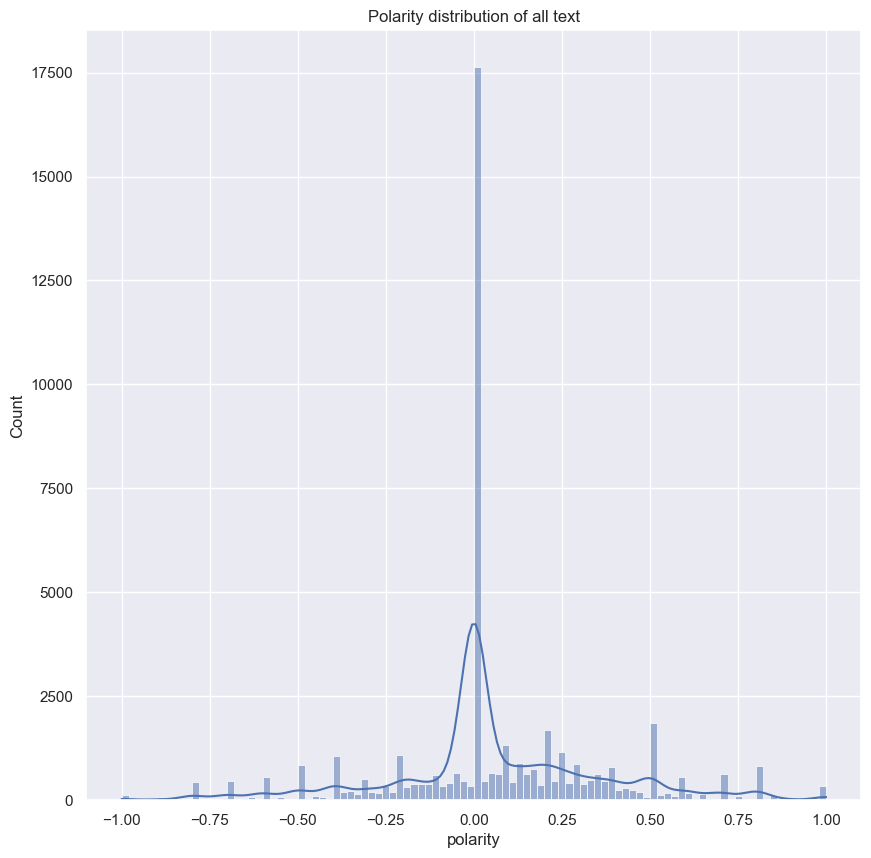

In [19]:
# Visualising polarity distribution

plt.figure(figsize=(10, 10))
sns.histplot(df["polarity"], bins=100, kde=True)
plt.title("Polarity distribution of all text")
plt.show()


#### Polarity Analysis by Target Type

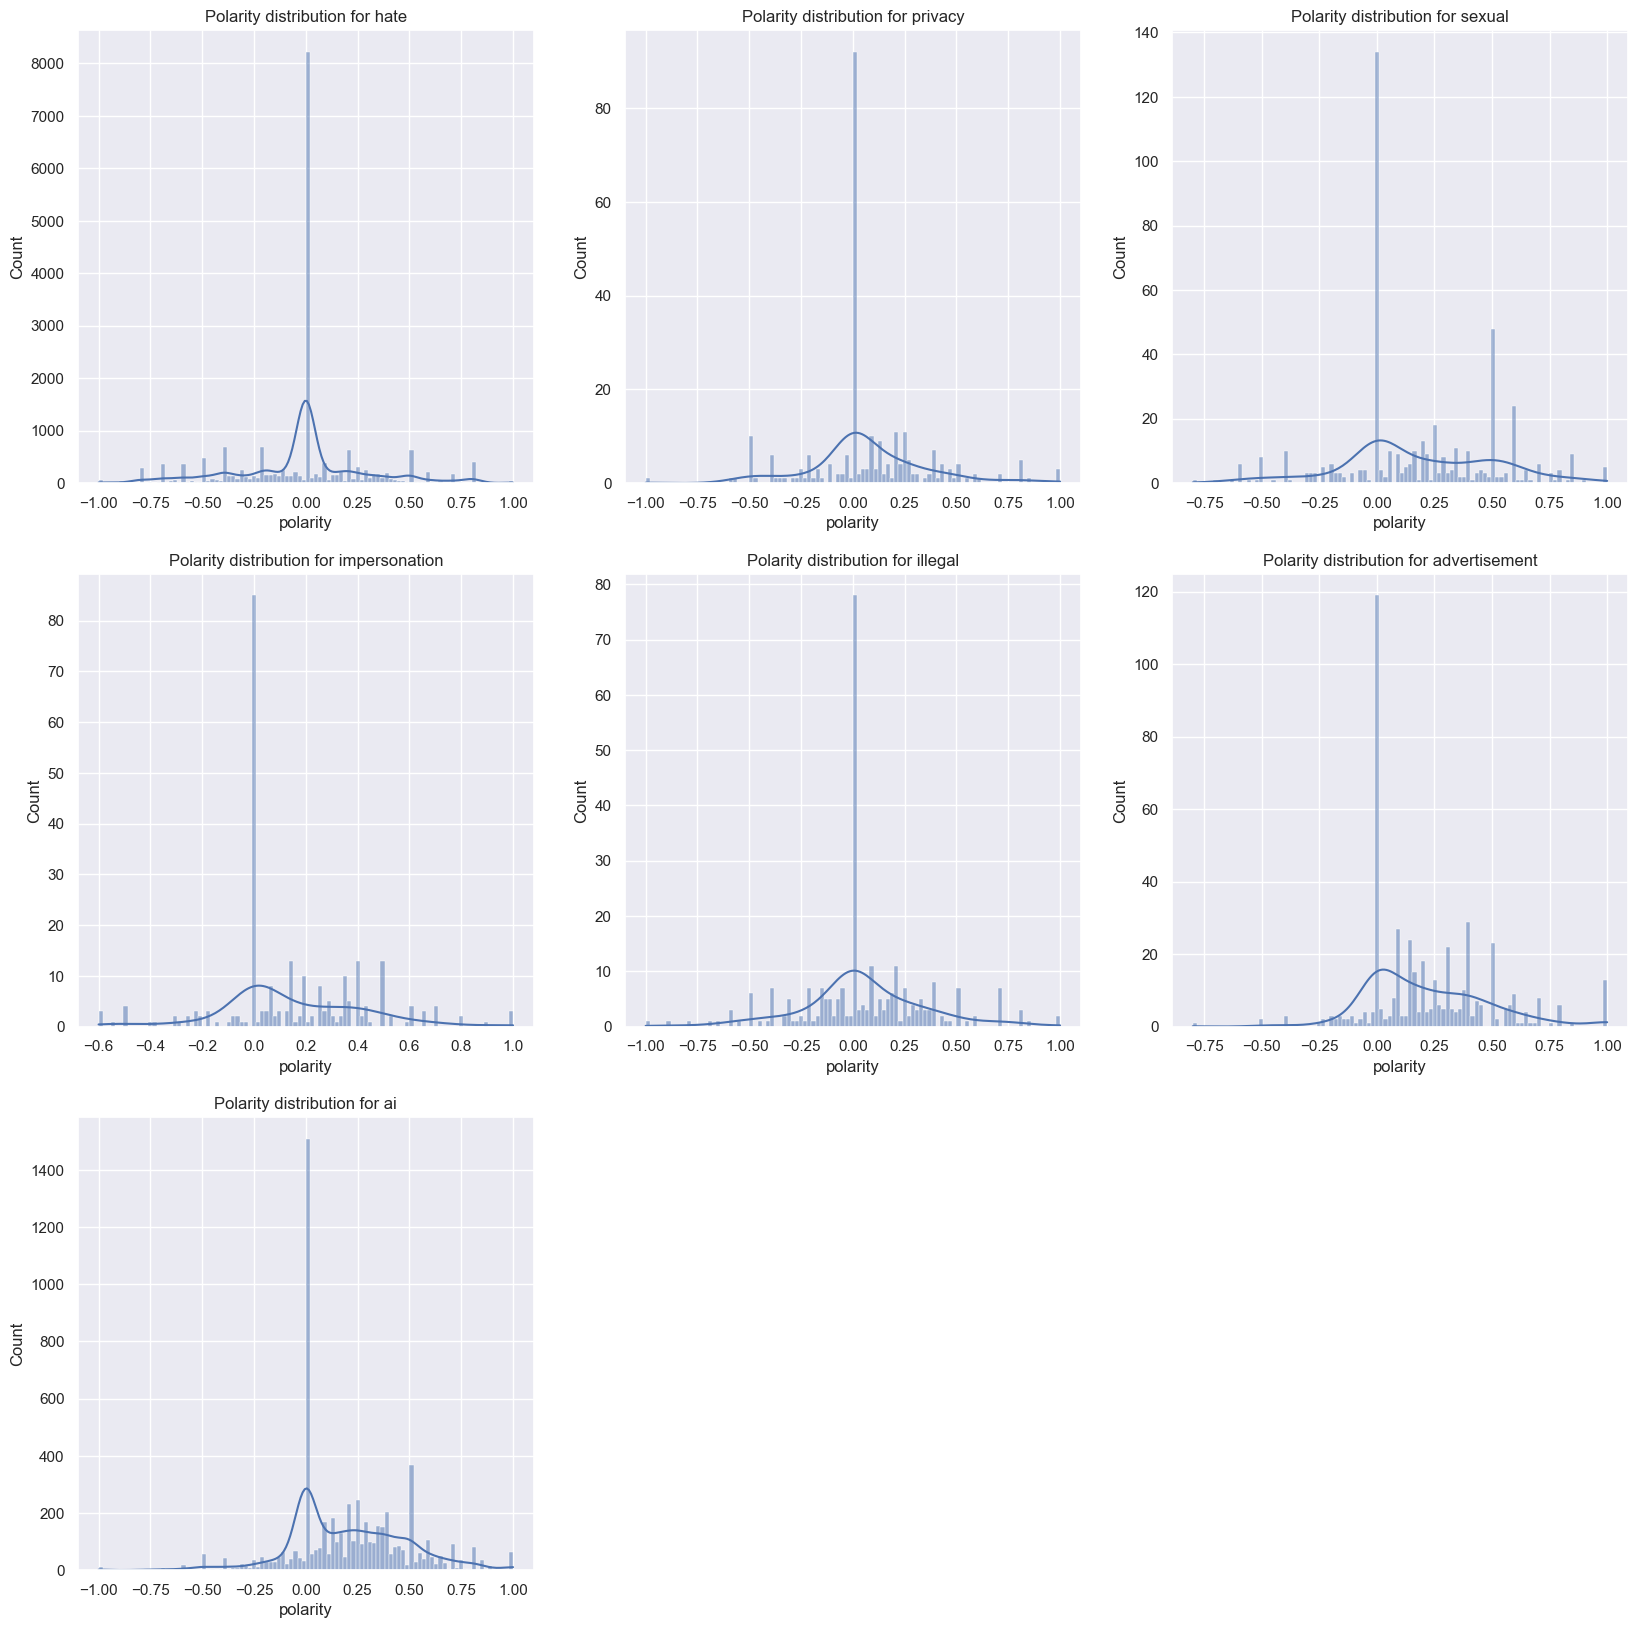

In [20]:
# Plotting polarity distribution for each target in TARGET_VARS in subplots

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, target in enumerate(TARGET_VARS):
    sns.histplot(df[df[target] == 1]["polarity"], bins=100, kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Polarity distribution for {target}")
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)


In [21]:
# Merge cluster_df and df on index

df_merged = df.merge(cluster_df, on="body")

In [22]:
df_merged.to_csv("data/df_merged.csv", index=False)

In [23]:
df_merged = pd.read_csv("data/df_merged.csv")

In [24]:
df_merged

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                   kalleron design refuse collection recycling sites hear huge demand nowadays   
1                                                                                                                                                                                                                                                                                                 hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift   
2      milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas   
3                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
4                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...   
52129                                                                                                                                                                                                                                                                                                                                                                        contract mobile 11 mnths latest motorola nokia etc free double mins text orange tariffs pm callback remove records   
52130                                                                                                                                                                                                                                                                                                                                                                                         want latest video handset 750 anytime network mins half price line rental reply delivery tomorrow   
52131                                                                                                                           

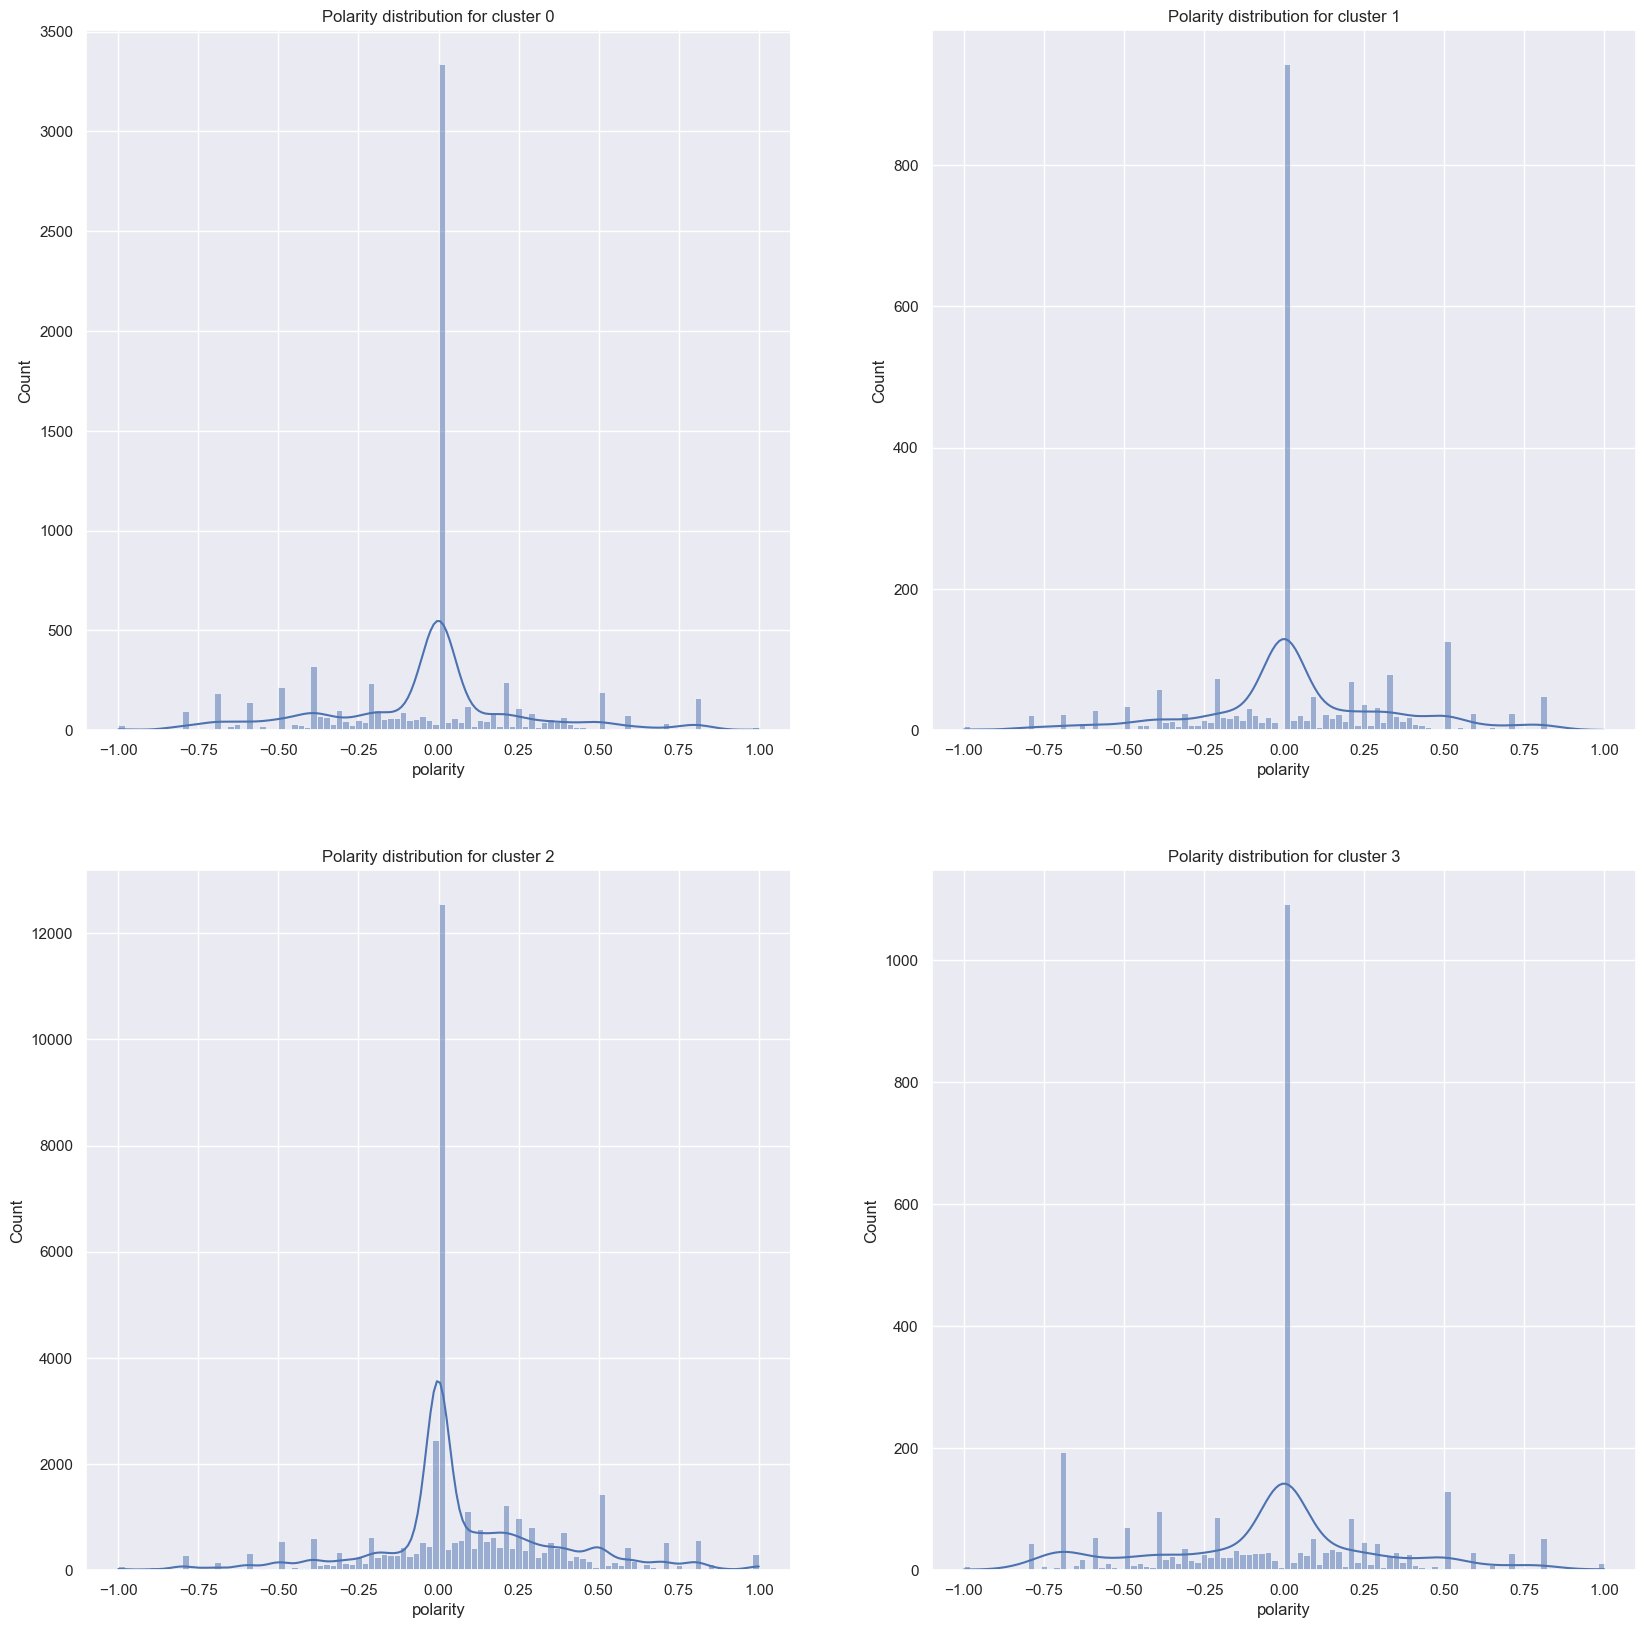

In [25]:
# Plotting polarity distribution for each cluster in subplots

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, cluster in enumerate(range(n_clusters)):
    sns.histplot(df_merged[df_merged["cluster"] == cluster]["polarity"], bins=100, kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"Polarity distribution for cluster {cluster}")


### Perplexity Analysis

In [26]:
def train_MLE_model(df_train, n=1):
    '''This function takes in a dataframe and returns a trained MLE model.
    
    Args:
        df_train (pd.DataFrame): A dataframe containing the training data
        n (int): The n-gram to be used
        
    Returns:
        model (nltk.model.ngram.NgramModel): A trained MLE model
    '''

    train_sentences = list(df_train['body'].values)
    tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                    for sent in train_sentences]
    train_data, padded_vocab = padded_everygram_pipeline(n, tokenized_text)
    model = MLE(n)
    model.fit(train_data, padded_vocab)
    return model

def perplexity(model, df_test, n=1):
    '''This function takes in a trained MLE model and a dataframe and returns a dataframe containing the perplexity of each sentence.
    
    Args:
        model (nltk.model.ngram.NgramModel): A trained MLE model
        df_test (pd.DataFrame): A dataframe containing the test data
        n (int): The n-gram to be used
        
    Returns:
        results (pd.DataFrame): A dataframe containing the perplexity of each sentence
    '''
    
    test_sentences = list(df_test['body'].values)
    tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                    for sent in test_sentences]
    test_data, _ = padded_everygram_pipeline(n, tokenized_text)
    results = {"body":[], "perplexity":[]}
    for i, test in enumerate(test_data):
        results["body"].append(test_sentences[i])
        results["perplexity"].append(model.perplexity(test))

    return pd.DataFrame(results)

In [27]:
# Perplexity for unigram model

df_train, df_test = train_test_split(df_merged, test_size=0.7, random_state=RANDOM_STATE, stratify=df_merged["ai"])
mle_unigram_model = train_MLE_model(df_train, n=1)
perplexity_unigram_results_df = perplexity(mle_unigram_model, df_test, n=1)

In [28]:
df_test = df_test.sort_values(by="body").reset_index(drop=True)
perplexity_unigram_results_df = perplexity_unigram_results_df.sort_values(by="body").reset_index(drop=True)

In [29]:
# merge with df_test on index
perplexity_unigram_results_df_merged = df_test.merge(perplexity_unigram_results_df, left_index=True, right_index=True).drop(columns=["body_y"]).rename(columns={"body_x": "body"})

In [30]:
perplexity_unigram_results_df_merged

body  \
0                                                                      01101101010100111100 never use prime due fact stuff included subscription mixed store pay movies shows big also fuck amazon   
1                                                                                                                013ander get many conservatives resent left looking insist digging deep hole live   
2                                                                                                                                                                 01takesthelead bitch use whipers   
3      03madara05 imagine sexually assaulting 13 year old distributing child porn snitching gang members still walking around like fact happened might actually make guy luckiest piece shit earth   
4                                                                                                         049at never tell truth ask stuff want someone stay 510 years underpay game play assholes   
...                                                                                                                                                                                            ...   
36489                                                                                                                                                                            zuko gets bitches   
36490                                                                                                                                                                                   zwaaad fag   
36491                                                                                                                      zz9za like mike pence charisma charm wet paper bag people see less like   
36492                                                                                                                              zzrsteve recipe dr sheldon cooper noble prize winning physicist   
36493                                                                                    zzrsteve shit like earlier games makes march madness possibly greatest spectacle sport least one greatest   

       hate  privacy  sexual  impersonation  illegal  advertisement  ai  \
0         0        0       0              0        0              0   0   
1         0        0       0              0        0              0   0   
2         1        0       0              0        0              0   0   
3         0        0       0              0        1              0   0   
4         0        0       0              0        0              0   0   
...     ...      ...     ...            ...      ...            ...  ..   
36489     1        0       0              0        0              0   0   
36490     0        0       0              0        0              0   0   
36491     0        0       0              0        0              0   0   
36492     0        0       0              0        0              0   0   
36493     0        0       0              0        0              0   0   

       polarity  cluster  perplexity  
0     -0.131250        2         inf  
1      0.159091        2         inf  
2      0.000000        0         inf  
3      0.100000        2         inf  
4     -0.400000        2         inf  
...         ...      ...         ...  
36489  0.000000        3         inf  
36490  0.000000        2         inf  
36491 -0.133333        2         inf  
36492  0.550000        2         inf  
36493  0.300000        2         inf  

[36494 rows x 11 columns]

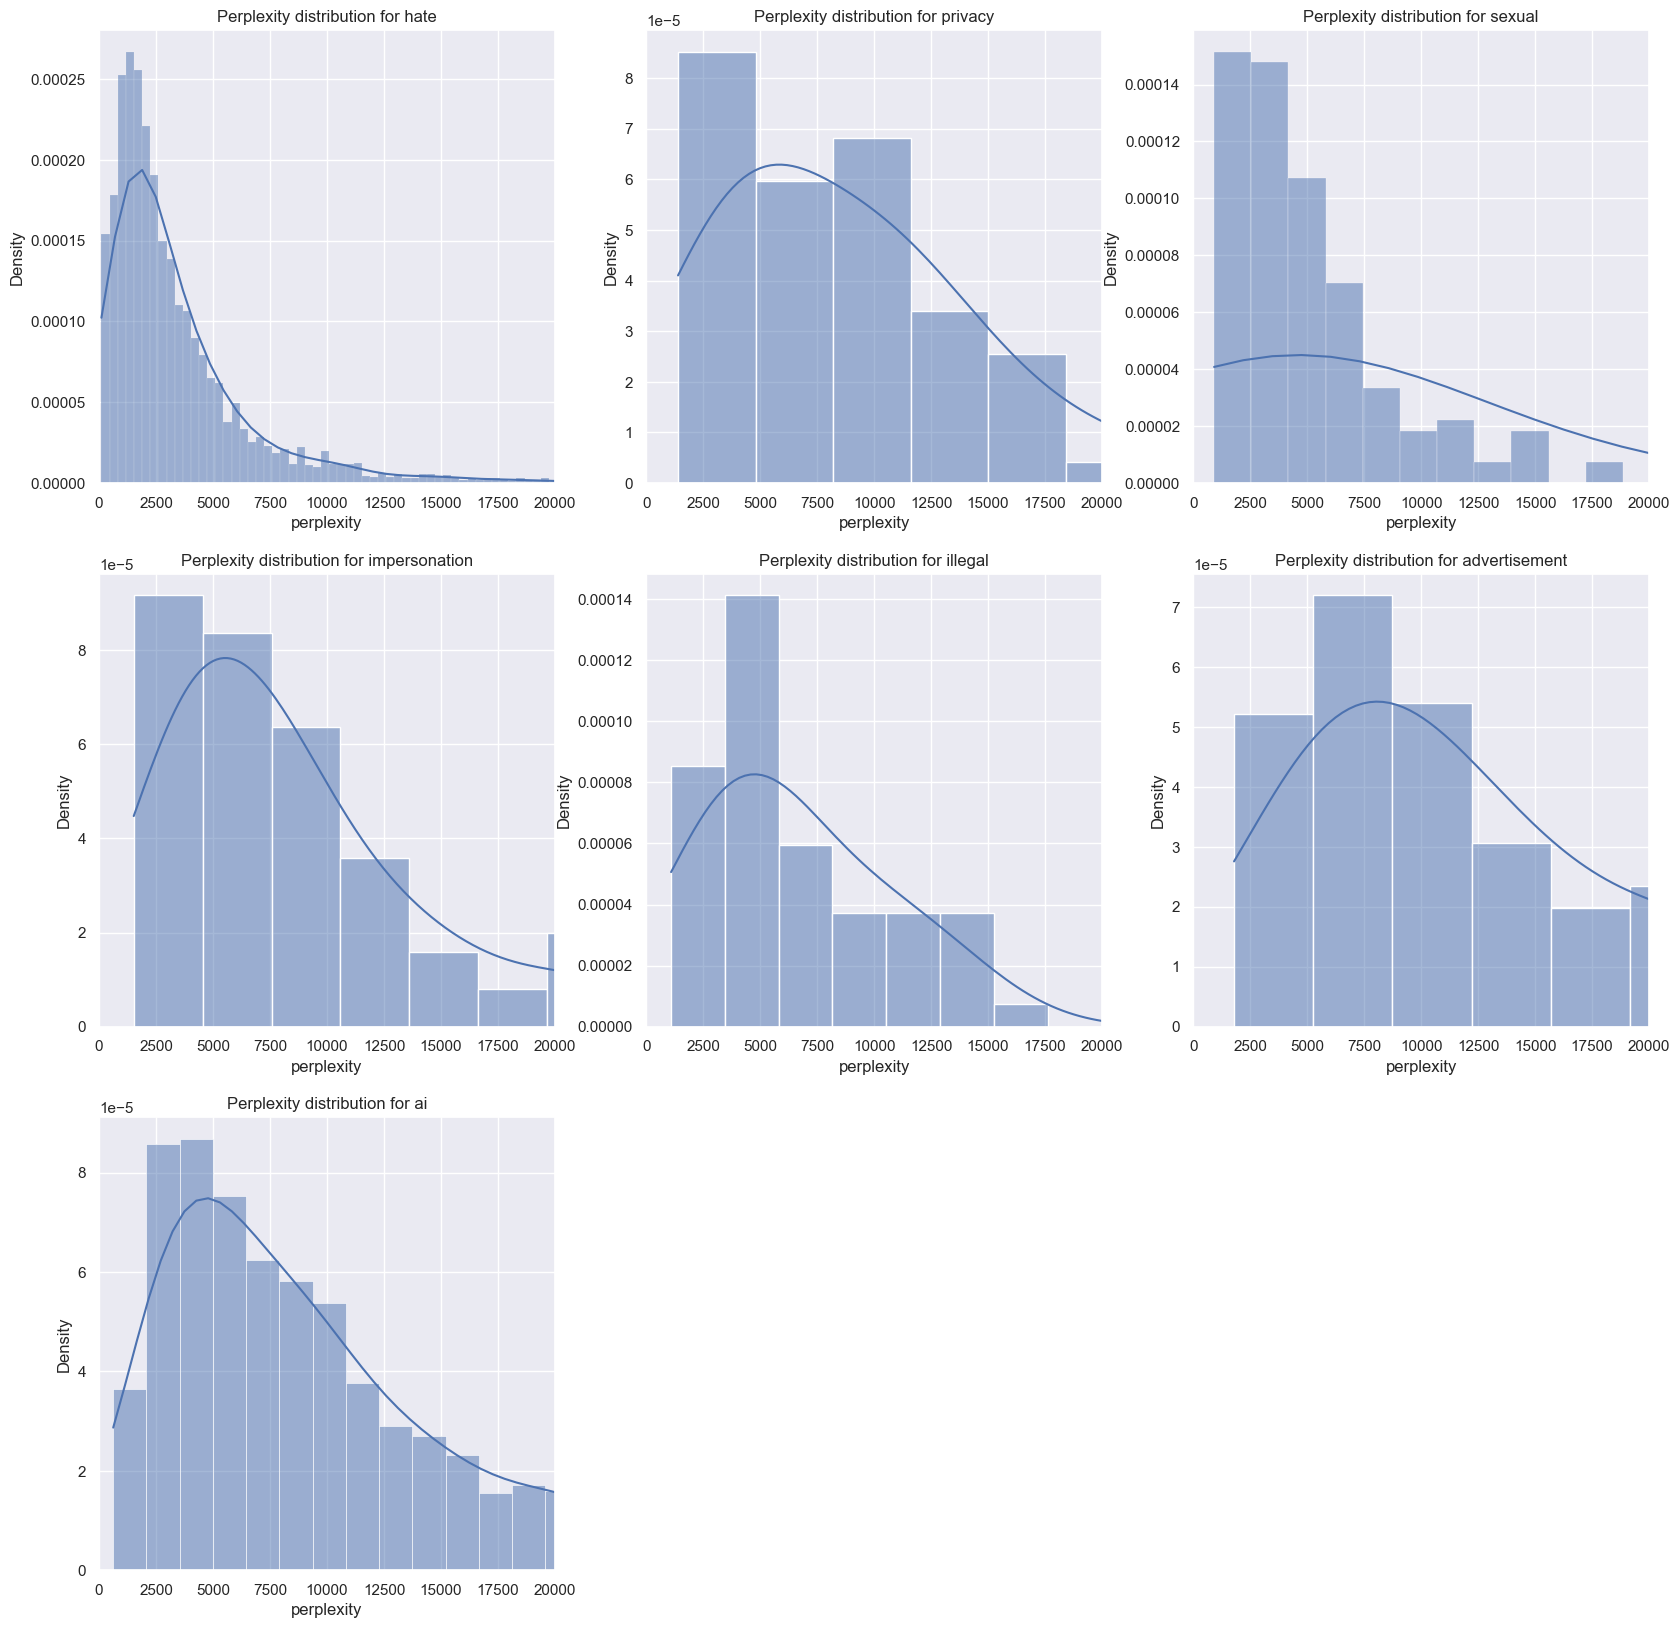

In [31]:
# plotting distribution of perplexity for unigram model for each target

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, target in enumerate(TARGET_VARS):
    sns.histplot(perplexity_unigram_results_df_merged[perplexity_unigram_results_df_merged[target] == 1]["perplexity"], kde=True, ax=axes[i//3, i%3], stat="density")
    axes[i//3, i%3].set_xlim(0, 20000)
    axes[i//3, i%3].set_title(f"Perplexity distribution for {target}")
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)



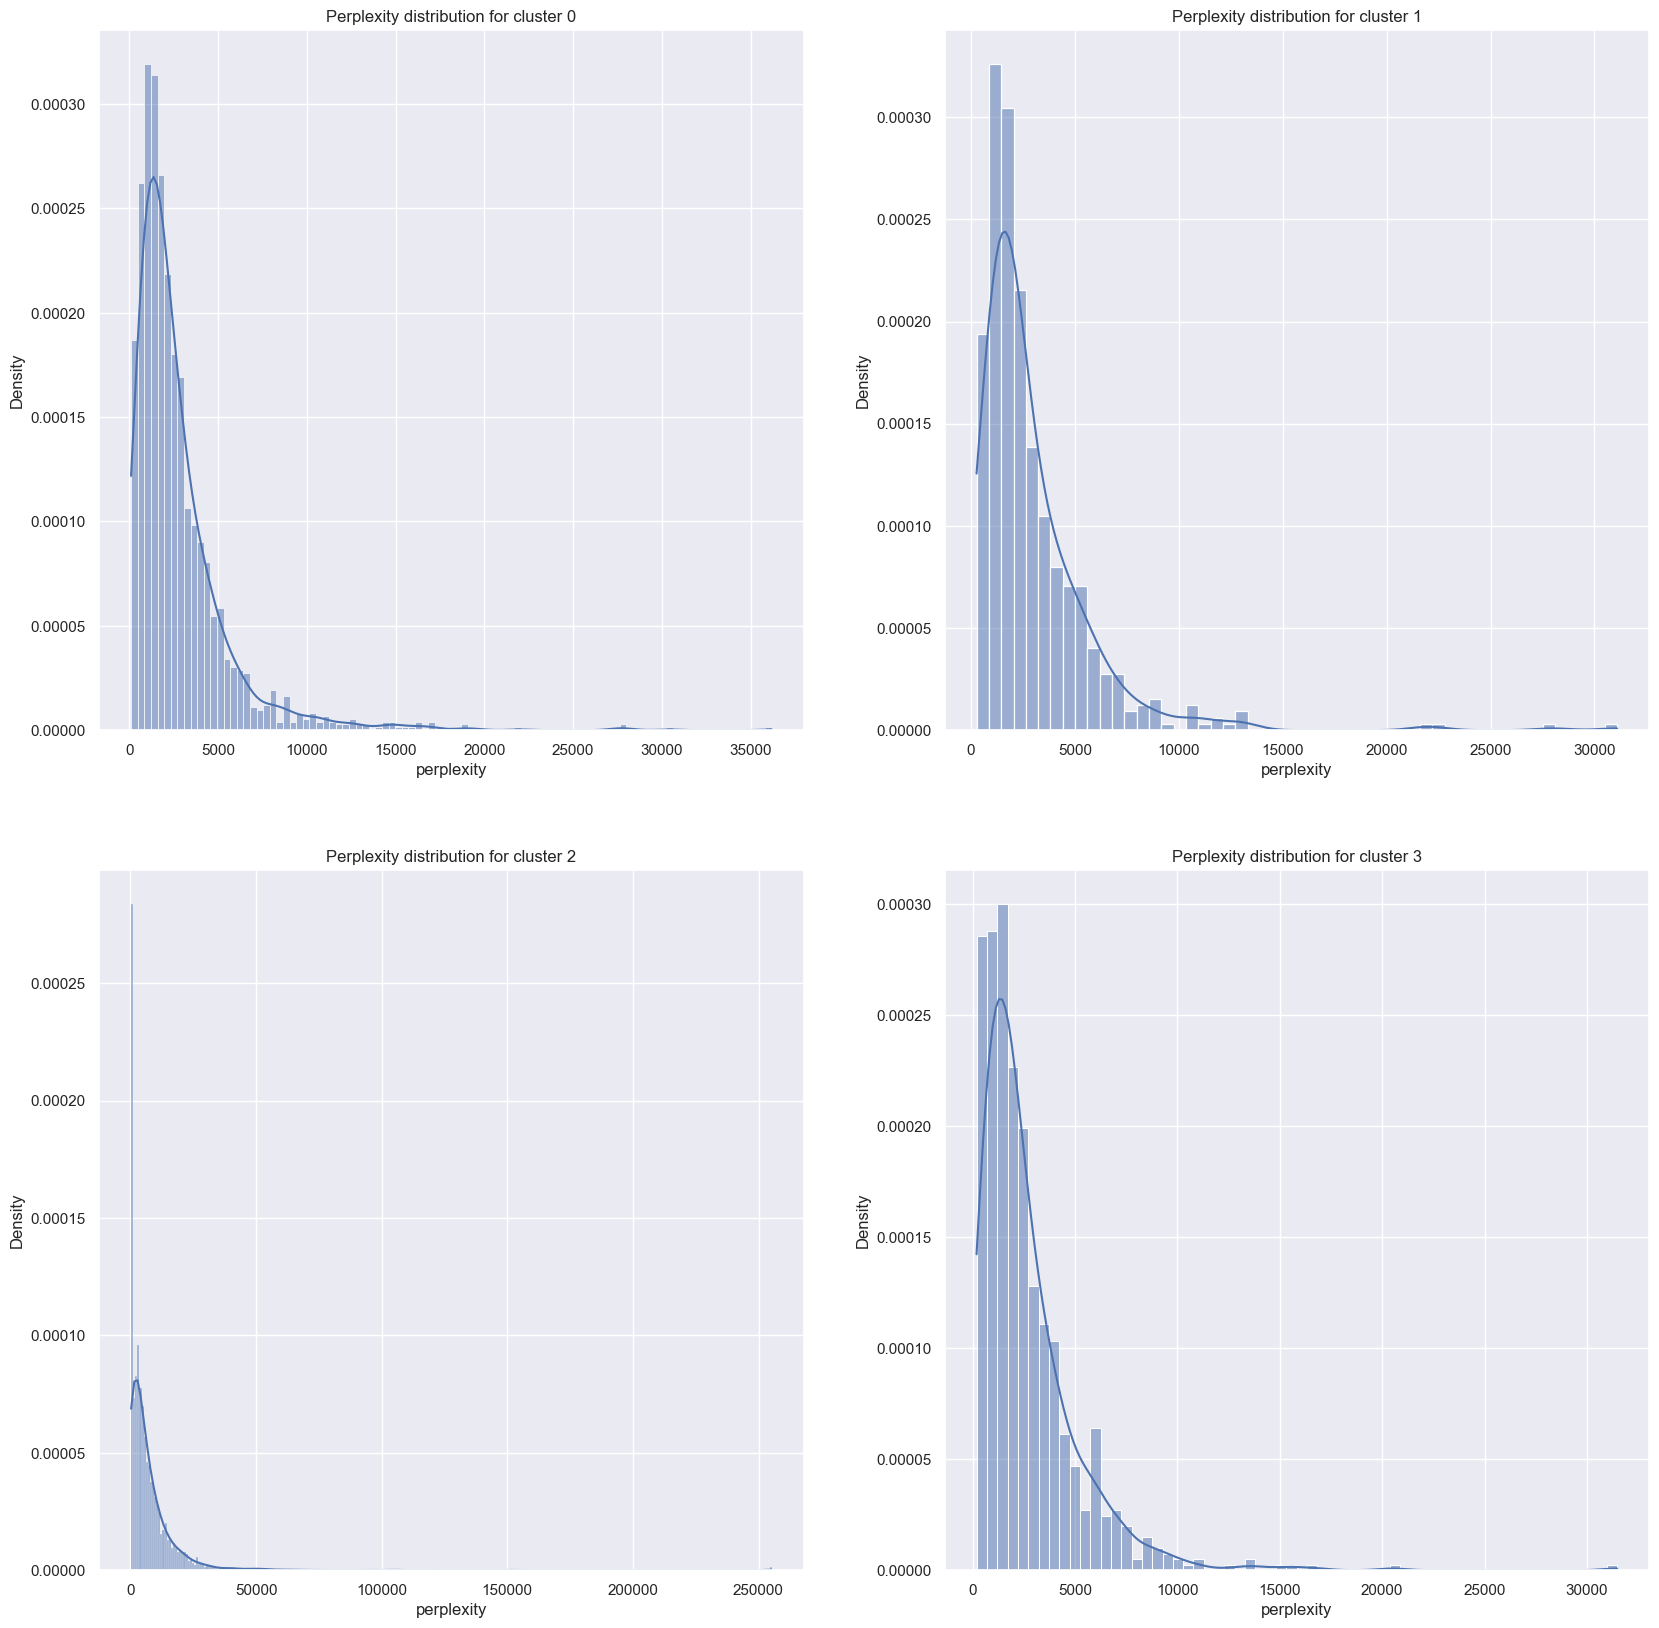

In [32]:
# plotting distribution of perplexity for unigram model for each cluster

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i in range(n_clusters):
    sns.histplot(perplexity_unigram_results_df_merged[perplexity_unigram_results_df_merged["cluster"] == i]["perplexity"], kde=True, ax=axes[i//2, i%2], stat="density")
    axes[i//2, i%2].set_title(f"Perplexity distribution for cluster {i}")

In [33]:
perplexity_unigram_results_df_merged.to_csv("data/perplexity_unigram_results_df_merged.csv", index=False)

In [34]:
perplexity_unigram_results_df_merged = pd.read_csv("data/perplexity_unigram_results_df_merged.csv")

### Burstiness Analysis

In [35]:
df_merged

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                   kalleron design refuse collection recycling sites hear huge demand nowadays   
1                                                                                                                                                                                                                                                                                                 hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift   
2      milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas   
3                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
4                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...   
52129                                                                                                                                                                                                                                                                                                                                                                        contract mobile 11 mnths latest motorola nokia etc free double mins text orange tariffs pm callback remove records   
52130                                                                                                                                                                                                                                                                                                                                                                                         want latest video handset 750 anytime network mins half price line rental reply delivery tomorrow   
52131                                                                                                                           

In [36]:
# Burstiness analysis

def calculate_burstiness(text):
    '''This function takes in a string and returns the burstiness of the text.
    
    Args:
        text (str): A string containing the text
        
    Returns:
        burstiness (float): The burstiness of the text
    '''
    
    tokens = nltk.word_tokenize(text)
    word_freq = nltk.FreqDist(tokens)
    freq_values = np.array(list(word_freq.values()))
    mean = np.mean(freq_values)
    variance = np.var(freq_values)
    burstiness = (variance - mean) / mean
    return abs(burstiness)


In [37]:
df_merged["burstiness"] = df_merged["body"].apply(lambda x: calculate_burstiness(x))

In [38]:
df_merged

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                   kalleron design refuse collection recycling sites hear huge demand nowadays   
1                                                                                                                                                                                                                                                                                                 hotmeringue2880 hi economics graduate years experience risk analyst looking make career shift people community development management suggest good mentors connect get clarity navigate shift   
2      milenakowalska hey year finish bachelor degree informatics still sure next thinking master bioinformatics cannot find affordable option looking distance learning opportunities experience shown much easier combine full time job currently working software engineer interested natural sciences like biology physics mathematics especially theoretical maths economics banking etc also would like choose something specific informatics master like become expert area anyone ideas   
3                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
4                                                                                                                                                                                                                                           rstonerphd studying makes employees want leave jobs impact employees ability leave new job study look employees want stay well survey less min complete individuals remain anonymous httpswwwsurveymonkeycomr5ppcvt5httpswwwsurveymonkeycomr5ppcvt5   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...   
52129                                                                                                                                                                                                                                                                                                                                                                        contract mobile 11 mnths latest motorola nokia etc free double mins text orange tariffs pm callback remove records   
52130                                                                                                                                                                                                                                                                                                                                                                                         want latest video handset 750 anytime network mins half price line rental reply delivery tomorrow   
52131                                                                                                                           

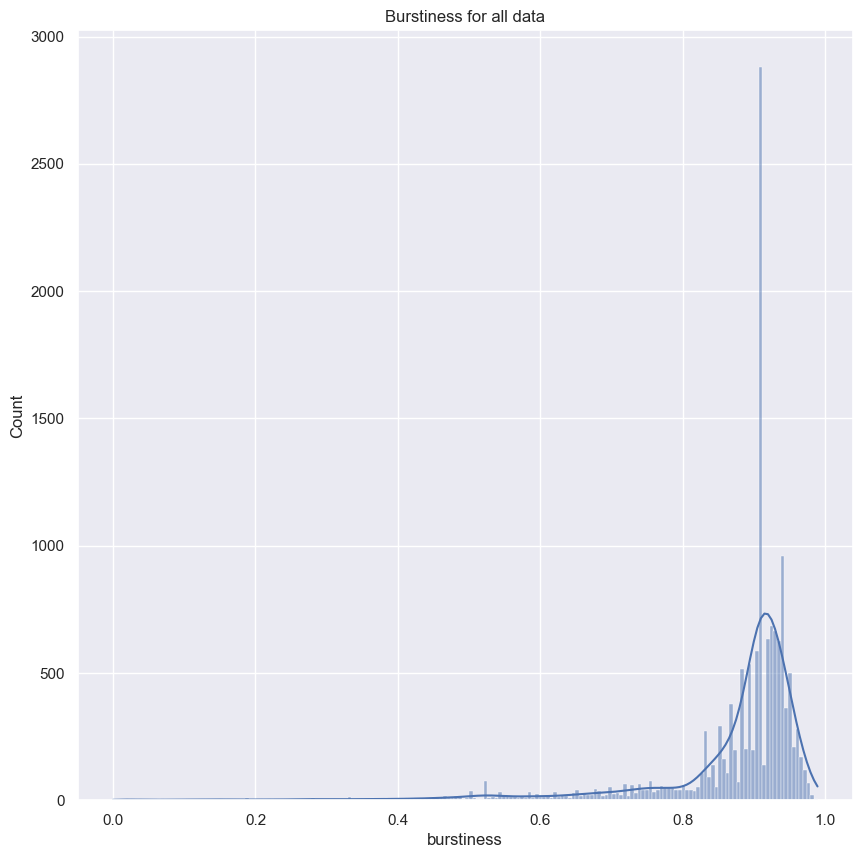

In [40]:
burstiness_filtered = df_merged[df_merged["burstiness"] < 1]

# plotting distribution of burstiness for all
plt.figure(figsize=(10, 10))
sns.histplot(burstiness_filtered["burstiness"], kde=True)
plt.title("Burstiness for all data")
plt.show()

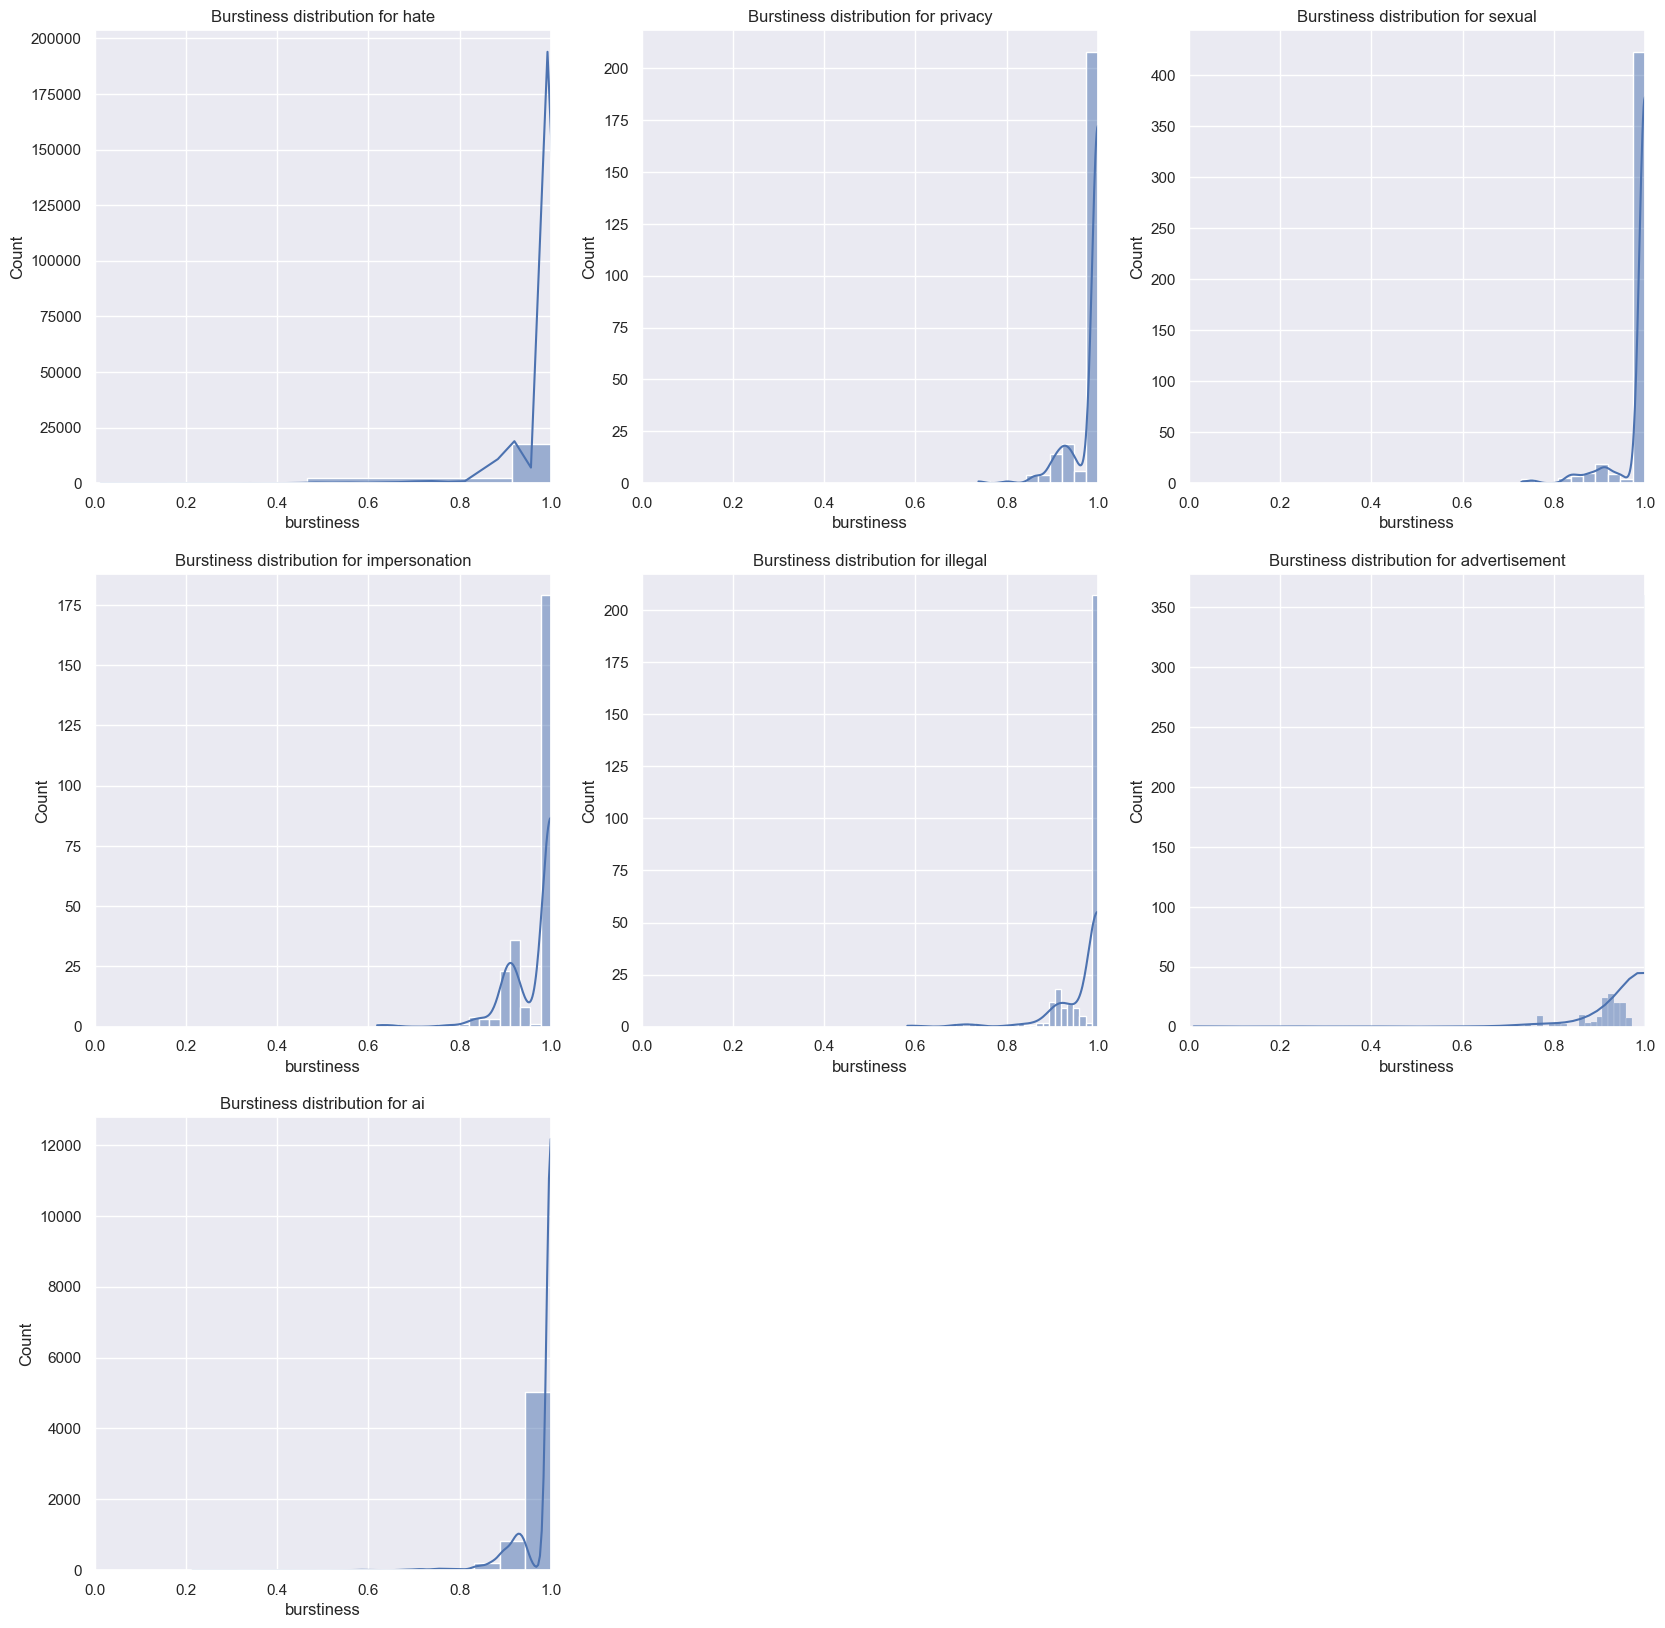

In [41]:
# plotting distribution of burstiness for unigram model for each target

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i, target in enumerate(TARGET_VARS):
    sns.histplot(df_merged[df_merged[target] == 1]["burstiness"], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_xlim(0, 1)
    axes[i//3, i%3].set_title(f"Burstiness distribution for {target}")
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)
